In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import DotPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [5]:
def make_churchland_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    # WARNING! This will produce a 2GB pickle file
    coherences = [0.032, 0.064, 0.128, 0.256, 0.512, 0.768]
    dfs = []
    columns = ('type', 'trial', 'nActions', 'coherence', 'RT', 'accuracy')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            for c, coherence in enumerate(coherences):
                # select preferred direction (0) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                if c >= len(emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time']): continue  # empty data
                dat = emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(dat[trial]['rt']) != float: continue  # empty data, skip
                    RT = int(dat[trial]['rt'])
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=1/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    dfs.append(pd.DataFrame([['monkey', trial, nActions, 100*coherence, RT/1000, accuracy]], columns=columns))

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_behavior.pkl")

In [ ]:
# make_churchland_behavior_dataframe()

In [2]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    # print(a, b, distance)
    return distance

def get_loss(simulated, empirical, coherences, bins=np.arange(0.0, 2.0, 0.2)):
    total_loss = 0
    for nActions in [2,4]:
        for coherence in coherences:
            rts_sim = simulated.query("nActions==@nActions & coherence==@coherence")['RT'].to_numpy()
            rts_emp = empirical.query("nActions==@nActions & coherence==@coherence")['RT'].to_numpy()
            hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
            hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
            normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
            normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
            chi_loss = chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp)
            mean_loss = np.abs(np.mean(rts_sim) - np.mean(rts_emp))
            median_loss = np.abs(np.median(rts_sim) - np.median(rts_emp))
            total_loss += chi_loss
            total_loss += median_loss
            print(nActions, coherence, 'chi2', chi_loss, 'median', median_loss, 'mean', mean_loss)
    return total_loss

In [3]:
def single_trial(
        coherence,
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        nNeurons=1000,
        max_rates=nengo.dists.Uniform(70, 100),
        rA=4.0,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        tmax=3,
        name="multiple_alternatives"):


    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7, 2.5)))
    for n, nActions in enumerate([2, 4]):
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=network_seed+perception_seed, max_rates=max_rates,
                            ramp=ramp, threshold=threshold, relative=relative)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > tmax:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
            correct = 1 if choice==net.inputs.correct else 0

        for a in range(nActions):
            axes[n].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
        for a in range(nActions):
            ideal = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
            axes[n].plot(sim.trange(), ideal, color=palette[a], label=f"True {a}", linestyle="--") 
        axes[n].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), color="red", linestyle=":")
        axes[n].set(xlabel="Time (s)", title=f"{nActions} Actions")
        axes[n].legend(loc='upper left', ncol=2)
    axes[0].set(ylabel=r"$\mathbf{V}(t)$")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

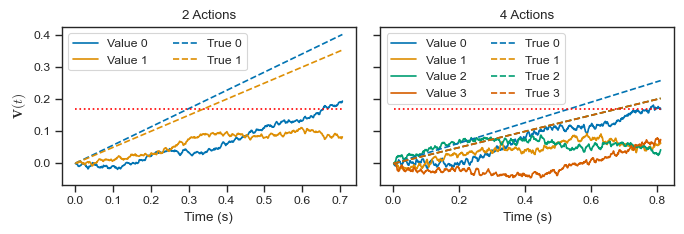

In [57]:
single_trial(coherence=0.064, ramp=1.07, relative=0.61, threshold=0.17, trials=100,
                nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03,
                perception_seed=2, name="dynamics6")

In [4]:
def simulate(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512, 0.768],
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        # nActions=2,
        nNeurons=1000,
        max_rates=nengo.dists.Uniform(70, 100),
        rA=4.0,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        estimator=np.mean,
        tmax=3,
        bins=np.arange(0.0, 2, 0.2),
        name="churchland_sim_behavior"):
    
    cohs = 100*np.array(coherences)
    if not load:
        columns = ('type', 'trial', 'coherence', 'nActions', 'RT', 'accuracy')  # same as Churchland dataframe
        dfs = []
        for nActions in [2, 4]:
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                # print(f"coherence {coherence}")
                for trial in range(trials):
                    inputs.create(coherence=coherence)
                    net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = True if choice==inputs.correct else False
                    print(f"nActions {nActions}, coherence {coherence}, trial {trial}, RT {RT}")
                    dfs.append(pd.DataFrame([['model', trial, 100*coherence, nActions, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        # data.to_pickle(f"data/{name}_{nActions}.pkl")
        data.to_pickle(f"data/{name}.pkl")
    else:
        # data = pd.read_pickle(f"data/{name}_{nActions}.pkl")
        data = pd.read_pickle(f"data/{name}.pkl")

    # churchland = pd.read_pickle('data/churchland2008_behavior.pkl').query("nActions==@nActions")
    churchland = pd.read_pickle('data/churchland2008_behavior.pkl')
    combined = pd.concat([churchland, data])
    loss = get_loss(combined.query("type=='model'"), combined.query("type=='monkey'"), cohs, bins=bins)
    print(f"loss {loss}")

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='nActions', style='type', palette=palette[:2], markers=True, ax=axes[0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue='nActions', style='type', palette=palette[:2], markers=True, ax=axes[1])
    axes[0].set(ylabel="Response Time (s)")
    axes[0].legend(ncols=2)
    # axes[1].set(xscale='log', xticks=[2, 3.2, 6.4, 12.8, 25.6, 51.4, 76.8], xlabel='Coherence', ylabel='Accuracy (%)')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_churchland_model2.svg")
    fig.savefig(f"plots/compare_churchland_model2.png", dpi=600)

    fig = sns.FacetGrid(combined, col='nActions', row="coherence", hue='type', palette=palette[:2], height=1, aspect=3.5, sharex=True, legend_out=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()
    fig.savefig(f"plots/churchland_compare2_RTs.svg")
    fig.savefig(f"plots/churchland_compare2_RTs.png", dpi=600)

## Simulate (behavior)

## Both

loss 1.5192968090892434


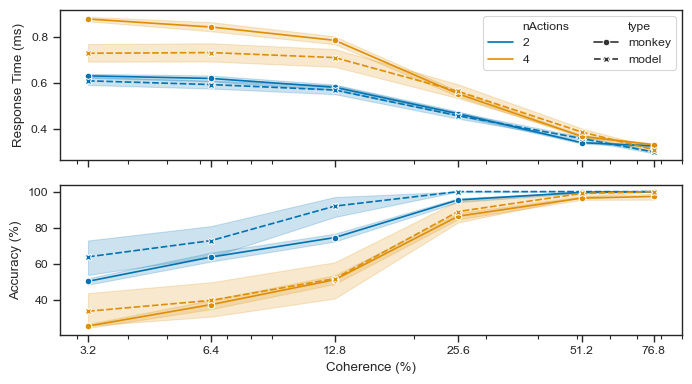

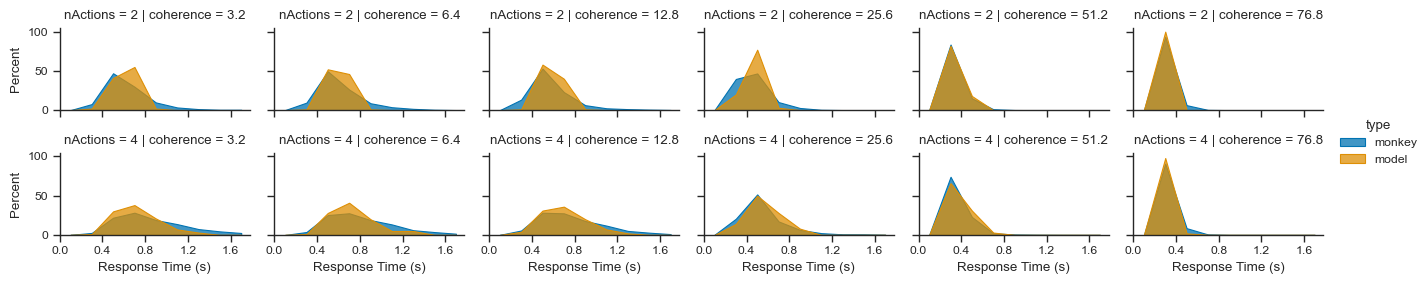

In [92]:
simulate(ramp=1.3, relative=0.48, threshold=0.21, trials=100, name="nov24a2", nNeurons=500, max_rates=nengo.dists.Uniform(50, 100), rA=2.0, load=True)

loss 3.5074798551902986


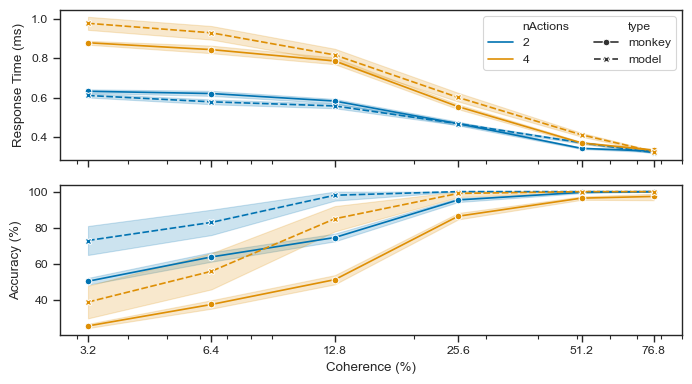

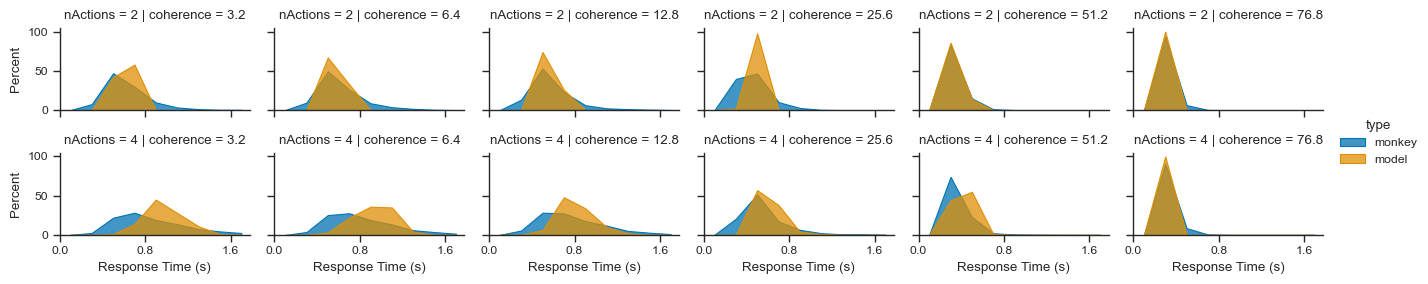

In [9]:
simulate(ramp=2.0, relative=0.3, threshold=0.4, trials=100, name="dec11b",
         nNeurons=500, max_rates=nengo.dists.Uniform(40, 60),
         rA=1.5, sigma=0.3, bins=np.arange(0.0, 2.0, 0.2), load=True)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


nActions 2, coherence 0.032, trial 0, RT 0.46900000000000003
nActions 2, coherence 0.032, trial 1, RT 0.516
nActions 2, coherence 0.032, trial 2, RT 0.419
nActions 2, coherence 0.032, trial 3, RT 0.341
nActions 2, coherence 0.032, trial 4, RT 0.544
nActions 2, coherence 0.032, trial 5, RT 1.071
nActions 2, coherence 0.032, trial 6, RT 0.502
nActions 2, coherence 0.032, trial 7, RT 0.617
nActions 2, coherence 0.032, trial 8, RT 0.5660000000000001
nActions 2, coherence 0.032, trial 9, RT 0.661
nActions 2, coherence 0.032, trial 10, RT 0.333
nActions 2, coherence 0.032, trial 11, RT 0.644
nActions 2, coherence 0.032, trial 12, RT 0.47900000000000004
nActions 2, coherence 0.032, trial 13, RT 0.603
nActions 2, coherence 0.032, trial 14, RT 0.809
nActions 2, coherence 0.032, trial 15, RT 1.034
nActions 2, coherence 0.032, trial 16, RT 0.552
nActions 2, coherence 0.032, trial 17, RT 0.541
nActions 2, coherence 0.032, trial 18, RT 0.423
nActions 2, coherence 0.032, trial 19, RT 0.483
nActions 

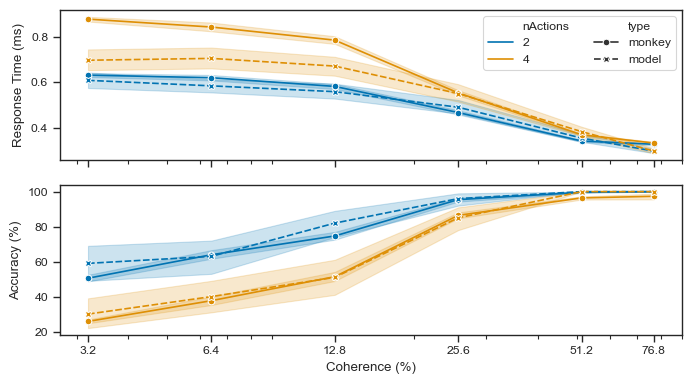

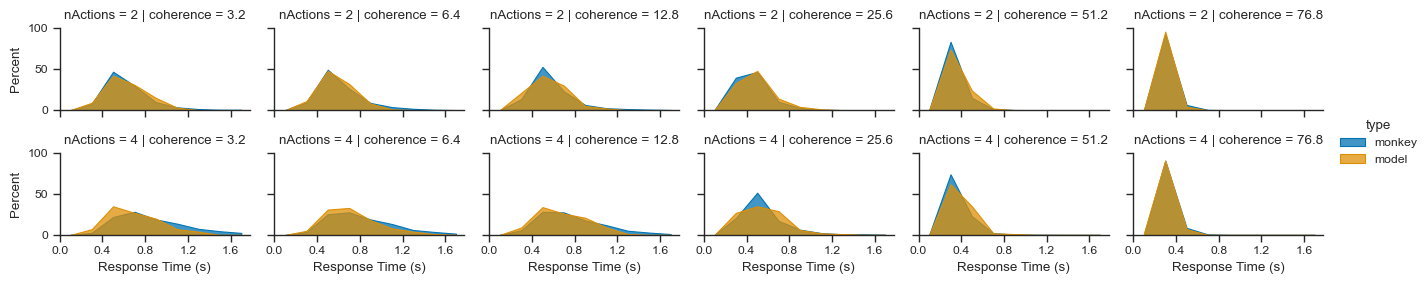

In [64]:
simulate(ramp=1.18, relative=0.63, threshold=0.17, trials=100, name="dec12a",
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100),
         rA=1.5, sigma=0.5, dt_sample=0.03, bins=np.arange(0.0, 2.0, 0.2), load=False)

In [6]:
simulate(ramp=1.07, relative=0.61, threshold=0.17, trials=100, name="dec13a",
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03, load=False)

nActions 2, coherence 0.032, trial 0, RT 0.494
nActions 2, coherence 0.032, trial 1, RT 0.545
nActions 2, coherence 0.032, trial 2, RT 0.999
nActions 2, coherence 0.032, trial 3, RT 0.528
nActions 2, coherence 0.032, trial 4, RT 0.76
nActions 2, coherence 0.032, trial 5, RT 0.8
nActions 2, coherence 0.032, trial 6, RT 0.405
nActions 2, coherence 0.032, trial 7, RT 0.544
nActions 2, coherence 0.032, trial 8, RT 0.48
nActions 2, coherence 0.032, trial 9, RT 0.736
nActions 2, coherence 0.032, trial 10, RT 0.645
nActions 2, coherence 0.032, trial 11, RT 0.502
nActions 2, coherence 0.032, trial 12, RT 0.782
nActions 2, coherence 0.032, trial 13, RT 1.052
nActions 2, coherence 0.032, trial 14, RT 0.782
nActions 2, coherence 0.032, trial 15, RT 0.724
nActions 2, coherence 0.032, trial 16, RT 0.319
nActions 2, coherence 0.032, trial 17, RT 0.616
nActions 2, coherence 0.032, trial 18, RT 0.582
nActions 2, coherence 0.032, trial 19, RT 0.489
nActions 2, coherence 0.032, trial 20, RT 0.744
nActio

KeyboardInterrupt: 

2 3.2 0.13023669816267128
2 6.4 0.027610378271523982
2 12.8 0.09563490518494688
2 25.6 0.07548481621542773
2 51.2 0.04483379826741781
2 76.8 0.0033611526851170703
4 3.2 0.11870646159718172
4 6.4 0.08197661344933675
4 12.8 0.04627584967647651
4 25.6 0.05975356975301077
4 51.2 0.08225471059823503
4 76.8 0.011966148733147174
loss 0.7780951025944925


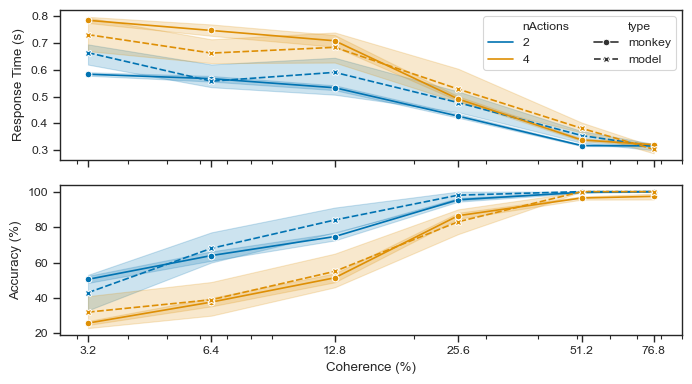

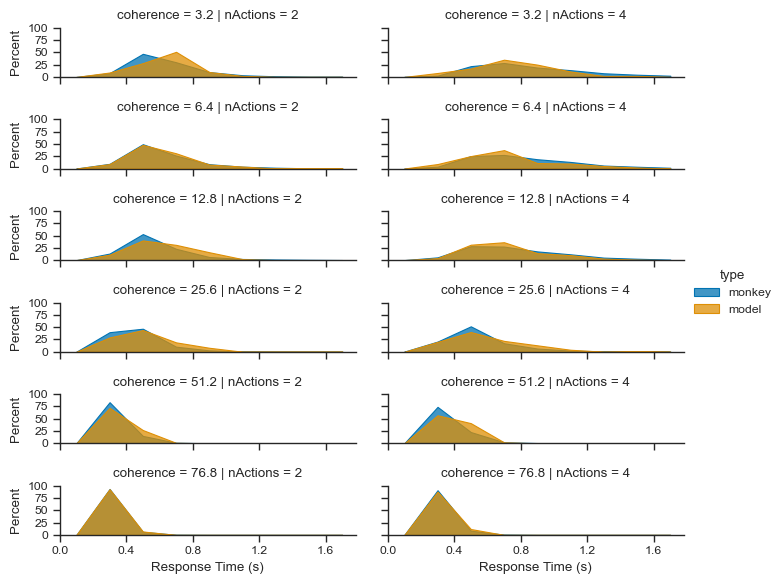

In [9]:
simulate(ramp=1.07, relative=0.61, threshold=0.17, trials=100, name="dec13a", estimator=np.median,
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03, load=True)

nActions 2, coherence 0.032, trial 0, RT 0.454
nActions 2, coherence 0.032, trial 1, RT 0.508
nActions 2, coherence 0.032, trial 2, RT 0.486
nActions 2, coherence 0.032, trial 3, RT 0.34900000000000003
nActions 2, coherence 0.032, trial 4, RT 0.848
nActions 2, coherence 0.032, trial 5, RT 0.808
nActions 2, coherence 0.032, trial 6, RT 0.528
nActions 2, coherence 0.032, trial 7, RT 0.623
nActions 2, coherence 0.032, trial 8, RT 0.5650000000000001
nActions 2, coherence 0.032, trial 9, RT 0.627
nActions 2, coherence 0.032, trial 10, RT 0.298
nActions 2, coherence 0.032, trial 11, RT 0.708
nActions 2, coherence 0.032, trial 12, RT 0.432
nActions 2, coherence 0.032, trial 13, RT 0.552
nActions 2, coherence 0.032, trial 14, RT 0.812
nActions 2, coherence 0.032, trial 15, RT 1.109
nActions 2, coherence 0.032, trial 16, RT 0.5650000000000001
nActions 2, coherence 0.032, trial 17, RT 0.525
nActions 2, coherence 0.032, trial 18, RT 0.46900000000000003
nActions 2, coherence 0.032, trial 19, RT 0.

nActions 2, coherence 0.032, trial 163, RT 0.8
nActions 2, coherence 0.032, trial 164, RT 0.463
nActions 2, coherence 0.032, trial 165, RT 0.796
nActions 2, coherence 0.032, trial 166, RT 0.653
nActions 2, coherence 0.032, trial 167, RT 0.452
nActions 2, coherence 0.032, trial 168, RT 0.374
nActions 2, coherence 0.032, trial 169, RT 0.722
nActions 2, coherence 0.032, trial 170, RT 0.34800000000000003
nActions 2, coherence 0.032, trial 171, RT 0.638
nActions 2, coherence 0.032, trial 172, RT 0.674
nActions 2, coherence 0.032, trial 173, RT 0.779
nActions 2, coherence 0.032, trial 174, RT 0.676
nActions 2, coherence 0.032, trial 175, RT 0.643
nActions 2, coherence 0.032, trial 176, RT 0.726
nActions 2, coherence 0.032, trial 177, RT 0.47900000000000004
nActions 2, coherence 0.032, trial 178, RT 0.765
nActions 2, coherence 0.032, trial 179, RT 0.754
nActions 2, coherence 0.032, trial 180, RT 0.622
nActions 2, coherence 0.032, trial 181, RT 0.534
nActions 2, coherence 0.032, trial 182, RT 

nActions 2, coherence 0.064, trial 127, RT 0.548
nActions 2, coherence 0.064, trial 128, RT 0.5660000000000001
nActions 2, coherence 0.064, trial 129, RT 0.36
nActions 2, coherence 0.064, trial 130, RT 0.369
nActions 2, coherence 0.064, trial 131, RT 0.855
nActions 2, coherence 0.064, trial 132, RT 0.716
nActions 2, coherence 0.064, trial 133, RT 0.323
nActions 2, coherence 0.064, trial 134, RT 0.727
nActions 2, coherence 0.064, trial 135, RT 0.532
nActions 2, coherence 0.064, trial 136, RT 0.803
nActions 2, coherence 0.064, trial 137, RT 0.492
nActions 2, coherence 0.064, trial 138, RT 0.441
nActions 2, coherence 0.064, trial 139, RT 0.464
nActions 2, coherence 0.064, trial 140, RT 0.679
nActions 2, coherence 0.064, trial 141, RT 0.628
nActions 2, coherence 0.064, trial 142, RT 0.455
nActions 2, coherence 0.064, trial 143, RT 0.43
nActions 2, coherence 0.064, trial 144, RT 0.358
nActions 2, coherence 0.064, trial 145, RT 0.5730000000000001
nActions 2, coherence 0.064, trial 146, RT 0.

nActions 2, coherence 0.128, trial 92, RT 0.623
nActions 2, coherence 0.128, trial 93, RT 0.615
nActions 2, coherence 0.128, trial 94, RT 0.538
nActions 2, coherence 0.128, trial 95, RT 0.753
nActions 2, coherence 0.128, trial 96, RT 0.786
nActions 2, coherence 0.128, trial 97, RT 0.593
nActions 2, coherence 0.128, trial 98, RT 0.7030000000000001
nActions 2, coherence 0.128, trial 99, RT 0.392
nActions 2, coherence 0.128, trial 100, RT 0.757
nActions 2, coherence 0.128, trial 101, RT 0.329
nActions 2, coherence 0.128, trial 102, RT 0.47700000000000004
nActions 2, coherence 0.128, trial 103, RT 0.36
nActions 2, coherence 0.128, trial 104, RT 0.722
nActions 2, coherence 0.128, trial 105, RT 0.49
nActions 2, coherence 0.128, trial 106, RT 0.482
nActions 2, coherence 0.128, trial 107, RT 0.388
nActions 2, coherence 0.128, trial 108, RT 0.357
nActions 2, coherence 0.128, trial 109, RT 0.487
nActions 2, coherence 0.128, trial 110, RT 0.44
nActions 2, coherence 0.128, trial 111, RT 0.5
nActio

nActions 2, coherence 0.256, trial 57, RT 0.461
nActions 2, coherence 0.256, trial 58, RT 0.845
nActions 2, coherence 0.256, trial 59, RT 0.372
nActions 2, coherence 0.256, trial 60, RT 0.722
nActions 2, coherence 0.256, trial 61, RT 0.812
nActions 2, coherence 0.256, trial 62, RT 0.769
nActions 2, coherence 0.256, trial 63, RT 0.40700000000000003
nActions 2, coherence 0.256, trial 64, RT 0.468
nActions 2, coherence 0.256, trial 65, RT 0.394
nActions 2, coherence 0.256, trial 66, RT 0.511
nActions 2, coherence 0.256, trial 67, RT 0.607
nActions 2, coherence 0.256, trial 68, RT 0.437
nActions 2, coherence 0.256, trial 69, RT 0.404
nActions 2, coherence 0.256, trial 70, RT 0.34400000000000003
nActions 2, coherence 0.256, trial 71, RT 0.443
nActions 2, coherence 0.256, trial 72, RT 0.47000000000000003
nActions 2, coherence 0.256, trial 73, RT 0.302
nActions 2, coherence 0.256, trial 74, RT 0.312
nActions 2, coherence 0.256, trial 75, RT 0.535
nActions 2, coherence 0.256, trial 76, RT 0.34

nActions 2, coherence 0.512, trial 20, RT 0.228
nActions 2, coherence 0.512, trial 21, RT 0.47200000000000003
nActions 2, coherence 0.512, trial 22, RT 0.392
nActions 2, coherence 0.512, trial 23, RT 0.386
nActions 2, coherence 0.512, trial 24, RT 0.28
nActions 2, coherence 0.512, trial 25, RT 0.513
nActions 2, coherence 0.512, trial 26, RT 0.251
nActions 2, coherence 0.512, trial 27, RT 0.356
nActions 2, coherence 0.512, trial 28, RT 0.367
nActions 2, coherence 0.512, trial 29, RT 0.279
nActions 2, coherence 0.512, trial 30, RT 0.52
nActions 2, coherence 0.512, trial 31, RT 0.401
nActions 2, coherence 0.512, trial 32, RT 0.28400000000000003
nActions 2, coherence 0.512, trial 33, RT 0.395
nActions 2, coherence 0.512, trial 34, RT 0.357
nActions 2, coherence 0.512, trial 35, RT 0.339
nActions 2, coherence 0.512, trial 36, RT 0.292
nActions 2, coherence 0.512, trial 37, RT 0.368
nActions 2, coherence 0.512, trial 38, RT 0.337
nActions 2, coherence 0.512, trial 39, RT 0.557
nActions 2, co

nActions 2, coherence 0.512, trial 184, RT 0.533
nActions 2, coherence 0.512, trial 185, RT 0.503
nActions 2, coherence 0.512, trial 186, RT 0.395
nActions 2, coherence 0.512, trial 187, RT 0.354
nActions 2, coherence 0.512, trial 188, RT 0.352
nActions 2, coherence 0.512, trial 189, RT 0.41500000000000004
nActions 2, coherence 0.512, trial 190, RT 0.304
nActions 2, coherence 0.512, trial 191, RT 0.215
nActions 2, coherence 0.512, trial 192, RT 0.356
nActions 2, coherence 0.512, trial 193, RT 0.329
nActions 2, coherence 0.512, trial 194, RT 0.356
nActions 2, coherence 0.512, trial 195, RT 0.494
nActions 2, coherence 0.512, trial 196, RT 0.355
nActions 2, coherence 0.512, trial 197, RT 0.367
nActions 2, coherence 0.512, trial 198, RT 0.312
nActions 2, coherence 0.512, trial 199, RT 0.497
nActions 2, coherence 0.768, trial 0, RT 0.34400000000000003
nActions 2, coherence 0.768, trial 1, RT 0.23600000000000002
nActions 2, coherence 0.768, trial 2, RT 0.266
nActions 2, coherence 0.768, tria

nActions 2, coherence 0.768, trial 148, RT 0.249
nActions 2, coherence 0.768, trial 149, RT 0.254
nActions 2, coherence 0.768, trial 150, RT 0.217
nActions 2, coherence 0.768, trial 151, RT 0.363
nActions 2, coherence 0.768, trial 152, RT 0.266
nActions 2, coherence 0.768, trial 153, RT 0.231
nActions 2, coherence 0.768, trial 154, RT 0.28800000000000003
nActions 2, coherence 0.768, trial 155, RT 0.323
nActions 2, coherence 0.768, trial 156, RT 0.262
nActions 2, coherence 0.768, trial 157, RT 0.27
nActions 2, coherence 0.768, trial 158, RT 0.279
nActions 2, coherence 0.768, trial 159, RT 0.28500000000000003
nActions 2, coherence 0.768, trial 160, RT 0.316
nActions 2, coherence 0.768, trial 161, RT 0.28
nActions 2, coherence 0.768, trial 162, RT 0.317
nActions 2, coherence 0.768, trial 163, RT 0.333
nActions 2, coherence 0.768, trial 164, RT 0.316
nActions 2, coherence 0.768, trial 165, RT 0.294
nActions 2, coherence 0.768, trial 166, RT 0.277
nActions 2, coherence 0.768, trial 167, RT 

nActions 4, coherence 0.032, trial 111, RT 1.044
nActions 4, coherence 0.032, trial 112, RT 0.904
nActions 4, coherence 0.032, trial 113, RT 0.926
nActions 4, coherence 0.032, trial 114, RT 0.556
nActions 4, coherence 0.032, trial 115, RT 0.6
nActions 4, coherence 0.032, trial 116, RT 0.863
nActions 4, coherence 0.032, trial 117, RT 0.972
nActions 4, coherence 0.032, trial 118, RT 0.599
nActions 4, coherence 0.032, trial 119, RT 1.495
nActions 4, coherence 0.032, trial 120, RT 0.324
nActions 4, coherence 0.032, trial 121, RT 0.777
nActions 4, coherence 0.032, trial 122, RT 0.456
nActions 4, coherence 0.032, trial 123, RT 0.483
nActions 4, coherence 0.032, trial 124, RT 1.082
nActions 4, coherence 0.032, trial 125, RT 0.8130000000000001
nActions 4, coherence 0.032, trial 126, RT 0.774
nActions 4, coherence 0.032, trial 127, RT 0.736
nActions 4, coherence 0.032, trial 128, RT 0.683
nActions 4, coherence 0.032, trial 129, RT 0.972
nActions 4, coherence 0.032, trial 130, RT 0.529
nActions 

nActions 4, coherence 0.064, trial 75, RT 0.424
nActions 4, coherence 0.064, trial 76, RT 0.584
nActions 4, coherence 0.064, trial 77, RT 1.375
nActions 4, coherence 0.064, trial 78, RT 0.5690000000000001
nActions 4, coherence 0.064, trial 79, RT 1.089
nActions 4, coherence 0.064, trial 80, RT 0.769
nActions 4, coherence 0.064, trial 81, RT 0.709
nActions 4, coherence 0.064, trial 82, RT 0.591
nActions 4, coherence 0.064, trial 83, RT 0.467
nActions 4, coherence 0.064, trial 84, RT 0.722
nActions 4, coherence 0.064, trial 85, RT 1.043
nActions 4, coherence 0.064, trial 86, RT 0.932
nActions 4, coherence 0.064, trial 87, RT 0.935
nActions 4, coherence 0.064, trial 88, RT 0.744
nActions 4, coherence 0.064, trial 89, RT 0.75
nActions 4, coherence 0.064, trial 90, RT 0.922
nActions 4, coherence 0.064, trial 91, RT 0.516
nActions 4, coherence 0.064, trial 92, RT 0.516
nActions 4, coherence 0.064, trial 93, RT 0.757
nActions 4, coherence 0.064, trial 94, RT 1.436
nActions 4, coherence 0.064,

nActions 4, coherence 0.128, trial 38, RT 0.562
nActions 4, coherence 0.128, trial 39, RT 0.744
nActions 4, coherence 0.128, trial 40, RT 0.986
nActions 4, coherence 0.128, trial 41, RT 1.2530000000000001
nActions 4, coherence 0.128, trial 42, RT 0.5710000000000001
nActions 4, coherence 0.128, trial 43, RT 0.923
nActions 4, coherence 0.128, trial 44, RT 1.197
nActions 4, coherence 0.128, trial 45, RT 0.603
nActions 4, coherence 0.128, trial 46, RT 1.2650000000000001
nActions 4, coherence 0.128, trial 47, RT 0.732
nActions 4, coherence 0.128, trial 48, RT 0.726
nActions 4, coherence 0.128, trial 49, RT 0.482
nActions 4, coherence 0.128, trial 50, RT 0.842
nActions 4, coherence 0.128, trial 51, RT 0.641
nActions 4, coherence 0.128, trial 52, RT 0.638
nActions 4, coherence 0.128, trial 53, RT 0.812
nActions 4, coherence 0.128, trial 54, RT 0.591
nActions 4, coherence 0.128, trial 55, RT 0.435
nActions 4, coherence 0.128, trial 56, RT 0.523
nActions 4, coherence 0.128, trial 57, RT 0.769
n

nActions 4, coherence 0.256, trial 1, RT 0.709
nActions 4, coherence 0.256, trial 2, RT 0.6880000000000001
nActions 4, coherence 0.256, trial 3, RT 0.379
nActions 4, coherence 0.256, trial 4, RT 0.51
nActions 4, coherence 0.256, trial 5, RT 0.543
nActions 4, coherence 0.256, trial 6, RT 0.518
nActions 4, coherence 0.256, trial 7, RT 0.463
nActions 4, coherence 0.256, trial 8, RT 0.48
nActions 4, coherence 0.256, trial 9, RT 0.418
nActions 4, coherence 0.256, trial 10, RT 0.405
nActions 4, coherence 0.256, trial 11, RT 0.307
nActions 4, coherence 0.256, trial 12, RT 1.229
nActions 4, coherence 0.256, trial 13, RT 0.447
nActions 4, coherence 0.256, trial 14, RT 0.911
nActions 4, coherence 0.256, trial 15, RT 0.709
nActions 4, coherence 0.256, trial 16, RT 0.622
nActions 4, coherence 0.256, trial 17, RT 0.577
nActions 4, coherence 0.256, trial 18, RT 0.922
nActions 4, coherence 0.256, trial 19, RT 0.494
nActions 4, coherence 0.256, trial 20, RT 0.309
nActions 4, coherence 0.256, trial 21,

nActions 4, coherence 0.256, trial 165, RT 1.048
nActions 4, coherence 0.256, trial 166, RT 0.5
nActions 4, coherence 0.256, trial 167, RT 0.367
nActions 4, coherence 0.256, trial 168, RT 0.99
nActions 4, coherence 0.256, trial 169, RT 0.494
nActions 4, coherence 0.256, trial 170, RT 0.55
nActions 4, coherence 0.256, trial 171, RT 0.427
nActions 4, coherence 0.256, trial 172, RT 0.591
nActions 4, coherence 0.256, trial 173, RT 0.505
nActions 4, coherence 0.256, trial 174, RT 0.47500000000000003
nActions 4, coherence 0.256, trial 175, RT 0.497
nActions 4, coherence 0.256, trial 176, RT 0.504
nActions 4, coherence 0.256, trial 177, RT 0.511
nActions 4, coherence 0.256, trial 178, RT 0.965
nActions 4, coherence 0.256, trial 179, RT 0.313
nActions 4, coherence 0.256, trial 180, RT 0.491
nActions 4, coherence 0.256, trial 181, RT 0.971
nActions 4, coherence 0.256, trial 182, RT 0.537
nActions 4, coherence 0.256, trial 183, RT 0.528
nActions 4, coherence 0.256, trial 184, RT 0.381
nActions 4

nActions 4, coherence 0.512, trial 131, RT 0.333
nActions 4, coherence 0.512, trial 132, RT 0.251
nActions 4, coherence 0.512, trial 133, RT 0.34400000000000003
nActions 4, coherence 0.512, trial 134, RT 0.333
nActions 4, coherence 0.512, trial 135, RT 0.394
nActions 4, coherence 0.512, trial 136, RT 0.488
nActions 4, coherence 0.512, trial 137, RT 0.41200000000000003
nActions 4, coherence 0.512, trial 138, RT 0.299
nActions 4, coherence 0.512, trial 139, RT 0.264
nActions 4, coherence 0.512, trial 140, RT 0.306
nActions 4, coherence 0.512, trial 141, RT 0.327
nActions 4, coherence 0.512, trial 142, RT 0.48
nActions 4, coherence 0.512, trial 143, RT 0.336
nActions 4, coherence 0.512, trial 144, RT 0.47300000000000003
nActions 4, coherence 0.512, trial 145, RT 0.5690000000000001
nActions 4, coherence 0.512, trial 146, RT 0.373
nActions 4, coherence 0.512, trial 147, RT 0.372
nActions 4, coherence 0.512, trial 148, RT 0.396
nActions 4, coherence 0.512, trial 149, RT 0.292
nActions 4, coh

nActions 4, coherence 0.768, trial 95, RT 0.312
nActions 4, coherence 0.768, trial 96, RT 0.265
nActions 4, coherence 0.768, trial 97, RT 0.296
nActions 4, coherence 0.768, trial 98, RT 0.305
nActions 4, coherence 0.768, trial 99, RT 0.317
nActions 4, coherence 0.768, trial 100, RT 0.328
nActions 4, coherence 0.768, trial 101, RT 0.23
nActions 4, coherence 0.768, trial 102, RT 0.244
nActions 4, coherence 0.768, trial 103, RT 0.312
nActions 4, coherence 0.768, trial 104, RT 0.23800000000000002
nActions 4, coherence 0.768, trial 105, RT 0.28600000000000003
nActions 4, coherence 0.768, trial 106, RT 0.34600000000000003
nActions 4, coherence 0.768, trial 107, RT 0.31
nActions 4, coherence 0.768, trial 108, RT 0.296
nActions 4, coherence 0.768, trial 109, RT 0.255
nActions 4, coherence 0.768, trial 110, RT 0.357
nActions 4, coherence 0.768, trial 111, RT 0.359
nActions 4, coherence 0.768, trial 112, RT 0.343
nActions 4, coherence 0.768, trial 113, RT 0.299
nActions 4, coherence 0.768, trial

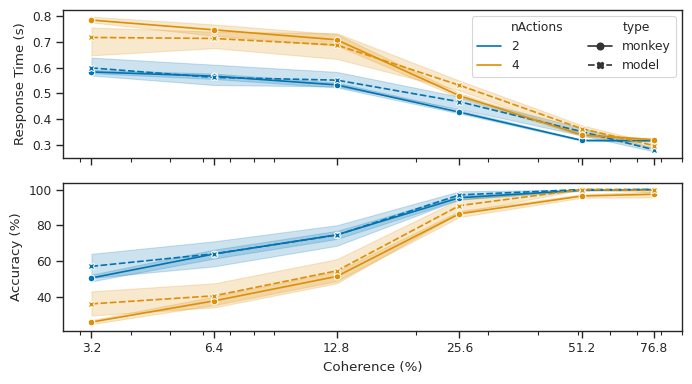

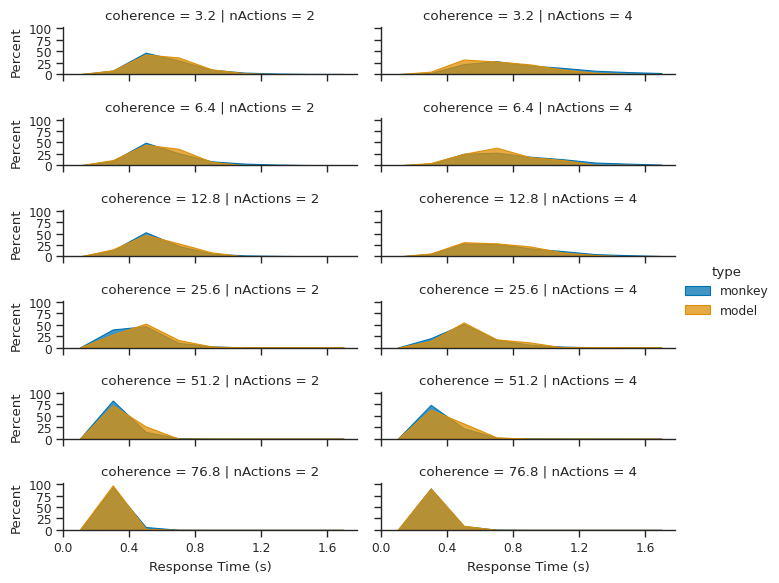

In [8]:
simulate(ramp=1.48, relative=0.59, threshold=0.22, trials=200, name="dec14full", estimator=np.median,
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03, load=False)

nActions 2, coherence 0.032, trial 0, RT 0.42
nActions 2, coherence 0.032, trial 1, RT 0.481
nActions 2, coherence 0.032, trial 2, RT 0.426
nActions 2, coherence 0.032, trial 3, RT 0.299
nActions 2, coherence 0.032, trial 4, RT 0.621
nActions 2, coherence 0.032, trial 5, RT 0.6900000000000001
nActions 2, coherence 0.032, trial 6, RT 0.34600000000000003
nActions 2, coherence 0.032, trial 7, RT 0.609
nActions 2, coherence 0.032, trial 8, RT 0.619
nActions 2, coherence 0.032, trial 9, RT 0.618
nActions 2, coherence 0.032, trial 10, RT 0.388
nActions 2, coherence 0.032, trial 11, RT 0.454
nActions 2, coherence 0.032, trial 12, RT 0.401
nActions 2, coherence 0.032, trial 13, RT 0.5720000000000001
nActions 2, coherence 0.032, trial 14, RT 0.584
nActions 2, coherence 0.032, trial 15, RT 0.613
nActions 2, coherence 0.032, trial 16, RT 0.41000000000000003
nActions 2, coherence 0.032, trial 17, RT 0.54
nActions 2, coherence 0.032, trial 18, RT 0.418
nActions 2, coherence 0.032, trial 19, RT 0.58

nActions 2, coherence 0.032, trial 163, RT 0.439
nActions 2, coherence 0.032, trial 164, RT 0.781
nActions 2, coherence 0.032, trial 165, RT 0.37
nActions 2, coherence 0.032, trial 166, RT 0.42
nActions 2, coherence 0.032, trial 167, RT 0.369
nActions 2, coherence 0.032, trial 168, RT 0.511
nActions 2, coherence 0.032, trial 169, RT 0.46
nActions 2, coherence 0.032, trial 170, RT 0.419
nActions 2, coherence 0.032, trial 171, RT 0.41300000000000003
nActions 2, coherence 0.032, trial 172, RT 0.482
nActions 2, coherence 0.032, trial 173, RT 0.457
nActions 2, coherence 0.032, trial 174, RT 0.372
nActions 2, coherence 0.032, trial 175, RT 0.509
nActions 2, coherence 0.032, trial 176, RT 0.671
nActions 2, coherence 0.032, trial 177, RT 0.525
nActions 2, coherence 0.032, trial 178, RT 0.417
nActions 2, coherence 0.032, trial 179, RT 0.486
nActions 2, coherence 0.032, trial 180, RT 0.54
nActions 2, coherence 0.032, trial 181, RT 0.512
nActions 2, coherence 0.032, trial 182, RT 0.446
nActions 2

nActions 2, coherence 0.064, trial 128, RT 0.397
nActions 2, coherence 0.064, trial 129, RT 0.503
nActions 2, coherence 0.064, trial 130, RT 0.369
nActions 2, coherence 0.064, trial 131, RT 0.603
nActions 2, coherence 0.064, trial 132, RT 0.511
nActions 2, coherence 0.064, trial 133, RT 0.622
nActions 2, coherence 0.064, trial 134, RT 0.6930000000000001
nActions 2, coherence 0.064, trial 135, RT 0.546
nActions 2, coherence 0.064, trial 136, RT 0.586
nActions 2, coherence 0.064, trial 137, RT 0.646
nActions 2, coherence 0.064, trial 138, RT 0.428
nActions 2, coherence 0.064, trial 139, RT 0.522
nActions 2, coherence 0.064, trial 140, RT 0.40700000000000003
nActions 2, coherence 0.064, trial 141, RT 0.492
nActions 2, coherence 0.064, trial 142, RT 0.491
nActions 2, coherence 0.064, trial 143, RT 0.458
nActions 2, coherence 0.064, trial 144, RT 0.481
nActions 2, coherence 0.064, trial 145, RT 0.535
nActions 2, coherence 0.064, trial 146, RT 0.516
nActions 2, coherence 0.064, trial 147, RT

nActions 2, coherence 0.128, trial 93, RT 0.518
nActions 2, coherence 0.128, trial 94, RT 0.354
nActions 2, coherence 0.128, trial 95, RT 0.484
nActions 2, coherence 0.128, trial 96, RT 0.483
nActions 2, coherence 0.128, trial 97, RT 0.541
nActions 2, coherence 0.128, trial 98, RT 0.44
nActions 2, coherence 0.128, trial 99, RT 0.374
nActions 2, coherence 0.128, trial 100, RT 0.34600000000000003
nActions 2, coherence 0.128, trial 101, RT 0.334
nActions 2, coherence 0.128, trial 102, RT 0.359
nActions 2, coherence 0.128, trial 103, RT 0.47800000000000004
nActions 2, coherence 0.128, trial 104, RT 0.559
nActions 2, coherence 0.128, trial 105, RT 0.528
nActions 2, coherence 0.128, trial 106, RT 0.392
nActions 2, coherence 0.128, trial 107, RT 0.40900000000000003
nActions 2, coherence 0.128, trial 108, RT 0.3
nActions 2, coherence 0.128, trial 109, RT 0.47400000000000003
nActions 2, coherence 0.128, trial 110, RT 0.376
nActions 2, coherence 0.128, trial 111, RT 0.51
nActions 2, coherence 0.

nActions 2, coherence 0.256, trial 55, RT 0.386
nActions 2, coherence 0.256, trial 56, RT 0.513
nActions 2, coherence 0.256, trial 57, RT 0.359
nActions 2, coherence 0.256, trial 58, RT 0.418
nActions 2, coherence 0.256, trial 59, RT 0.405
nActions 2, coherence 0.256, trial 60, RT 0.461
nActions 2, coherence 0.256, trial 61, RT 0.377
nActions 2, coherence 0.256, trial 62, RT 0.48
nActions 2, coherence 0.256, trial 63, RT 0.375
nActions 2, coherence 0.256, trial 64, RT 0.483
nActions 2, coherence 0.256, trial 65, RT 0.374
nActions 2, coherence 0.256, trial 66, RT 0.465
nActions 2, coherence 0.256, trial 67, RT 0.41600000000000004
nActions 2, coherence 0.256, trial 68, RT 0.5670000000000001
nActions 2, coherence 0.256, trial 69, RT 0.46
nActions 2, coherence 0.256, trial 70, RT 0.41100000000000003
nActions 2, coherence 0.256, trial 71, RT 0.584
nActions 2, coherence 0.256, trial 72, RT 0.55
nActions 2, coherence 0.256, trial 73, RT 0.483
nActions 2, coherence 0.256, trial 74, RT 0.501
nA

nActions 2, coherence 0.512, trial 18, RT 0.334
nActions 2, coherence 0.512, trial 19, RT 0.396
nActions 2, coherence 0.512, trial 20, RT 0.34600000000000003
nActions 2, coherence 0.512, trial 21, RT 0.374
nActions 2, coherence 0.512, trial 22, RT 0.429
nActions 2, coherence 0.512, trial 23, RT 0.395
nActions 2, coherence 0.512, trial 24, RT 0.269
nActions 2, coherence 0.512, trial 25, RT 0.41400000000000003
nActions 2, coherence 0.512, trial 26, RT 0.402
nActions 2, coherence 0.512, trial 27, RT 0.391
nActions 2, coherence 0.512, trial 28, RT 0.56
nActions 2, coherence 0.512, trial 29, RT 0.41500000000000004
nActions 2, coherence 0.512, trial 30, RT 0.363
nActions 2, coherence 0.512, trial 31, RT 0.375
nActions 2, coherence 0.512, trial 32, RT 0.335
nActions 2, coherence 0.512, trial 33, RT 0.339
nActions 2, coherence 0.512, trial 34, RT 0.493
nActions 2, coherence 0.512, trial 35, RT 0.379
nActions 2, coherence 0.512, trial 36, RT 0.362
nActions 2, coherence 0.512, trial 37, RT 0.433

nActions 2, coherence 0.512, trial 182, RT 0.342
nActions 2, coherence 0.512, trial 183, RT 0.326
nActions 2, coherence 0.512, trial 184, RT 0.341
nActions 2, coherence 0.512, trial 185, RT 0.35100000000000003
nActions 2, coherence 0.512, trial 186, RT 0.369
nActions 2, coherence 0.512, trial 187, RT 0.3
nActions 2, coherence 0.512, trial 188, RT 0.459
nActions 2, coherence 0.512, trial 189, RT 0.323
nActions 2, coherence 0.512, trial 190, RT 0.363
nActions 2, coherence 0.512, trial 191, RT 0.40700000000000003
nActions 2, coherence 0.512, trial 192, RT 0.361
nActions 2, coherence 0.512, trial 193, RT 0.319
nActions 2, coherence 0.512, trial 194, RT 0.324
nActions 2, coherence 0.512, trial 195, RT 0.41000000000000003
nActions 2, coherence 0.512, trial 196, RT 0.342
nActions 2, coherence 0.512, trial 197, RT 0.555
nActions 2, coherence 0.512, trial 198, RT 0.307
nActions 2, coherence 0.512, trial 199, RT 0.352
nActions 2, coherence 0.768, trial 0, RT 0.342
nActions 2, coherence 0.768, tr

nActions 2, coherence 0.768, trial 145, RT 0.367
nActions 2, coherence 0.768, trial 146, RT 0.32
nActions 2, coherence 0.768, trial 147, RT 0.375
nActions 2, coherence 0.768, trial 148, RT 0.337
nActions 2, coherence 0.768, trial 149, RT 0.387
nActions 2, coherence 0.768, trial 150, RT 0.337
nActions 2, coherence 0.768, trial 151, RT 0.333
nActions 2, coherence 0.768, trial 152, RT 0.274
nActions 2, coherence 0.768, trial 153, RT 0.387
nActions 2, coherence 0.768, trial 154, RT 0.38
nActions 2, coherence 0.768, trial 155, RT 0.39
nActions 2, coherence 0.768, trial 156, RT 0.373
nActions 2, coherence 0.768, trial 157, RT 0.325
nActions 2, coherence 0.768, trial 158, RT 0.34400000000000003
nActions 2, coherence 0.768, trial 159, RT 0.365
nActions 2, coherence 0.768, trial 160, RT 0.435
nActions 2, coherence 0.768, trial 161, RT 0.318
nActions 2, coherence 0.768, trial 162, RT 0.395
nActions 2, coherence 0.768, trial 163, RT 0.321
nActions 2, coherence 0.768, trial 164, RT 0.314
nActions 

nActions 4, coherence 0.032, trial 111, RT 0.722
nActions 4, coherence 0.032, trial 112, RT 0.8220000000000001
nActions 4, coherence 0.032, trial 113, RT 0.549
nActions 4, coherence 0.032, trial 114, RT 0.835
nActions 4, coherence 0.032, trial 115, RT 0.672
nActions 4, coherence 0.032, trial 116, RT 0.71
nActions 4, coherence 0.032, trial 117, RT 1.022
nActions 4, coherence 0.032, trial 118, RT 0.607
nActions 4, coherence 0.032, trial 119, RT 0.785
nActions 4, coherence 0.032, trial 120, RT 0.687
nActions 4, coherence 0.032, trial 121, RT 0.8130000000000001
nActions 4, coherence 0.032, trial 122, RT 0.651
nActions 4, coherence 0.032, trial 123, RT 0.848
nActions 4, coherence 0.032, trial 124, RT 0.511
nActions 4, coherence 0.032, trial 125, RT 0.877
nActions 4, coherence 0.032, trial 126, RT 0.579
nActions 4, coherence 0.032, trial 127, RT 0.629
nActions 4, coherence 0.032, trial 128, RT 0.731
nActions 4, coherence 0.032, trial 129, RT 0.762
nActions 4, coherence 0.032, trial 130, RT 0

nActions 4, coherence 0.064, trial 74, RT 0.904
nActions 4, coherence 0.064, trial 75, RT 0.733
nActions 4, coherence 0.064, trial 76, RT 0.398
nActions 4, coherence 0.064, trial 77, RT 1.002
nActions 4, coherence 0.064, trial 78, RT 0.651
nActions 4, coherence 0.064, trial 79, RT 0.678
nActions 4, coherence 0.064, trial 80, RT 0.621
nActions 4, coherence 0.064, trial 81, RT 0.5680000000000001
nActions 4, coherence 0.064, trial 82, RT 1.0
nActions 4, coherence 0.064, trial 83, RT 0.486
nActions 4, coherence 0.064, trial 84, RT 0.595
nActions 4, coherence 0.064, trial 85, RT 0.586
nActions 4, coherence 0.064, trial 86, RT 0.468
nActions 4, coherence 0.064, trial 87, RT 0.65
nActions 4, coherence 0.064, trial 88, RT 0.778
nActions 4, coherence 0.064, trial 89, RT 0.646
nActions 4, coherence 0.064, trial 90, RT 0.525
nActions 4, coherence 0.064, trial 91, RT 0.389
nActions 4, coherence 0.064, trial 92, RT 0.677
nActions 4, coherence 0.064, trial 93, RT 0.437
nActions 4, coherence 0.064, t

nActions 4, coherence 0.128, trial 38, RT 0.446
nActions 4, coherence 0.128, trial 39, RT 0.7000000000000001
nActions 4, coherence 0.128, trial 40, RT 0.641
nActions 4, coherence 0.128, trial 41, RT 0.79
nActions 4, coherence 0.128, trial 42, RT 0.767
nActions 4, coherence 0.128, trial 43, RT 0.8210000000000001
nActions 4, coherence 0.128, trial 44, RT 0.639
nActions 4, coherence 0.128, trial 45, RT 0.529
nActions 4, coherence 0.128, trial 46, RT 0.578
nActions 4, coherence 0.128, trial 47, RT 0.908
nActions 4, coherence 0.128, trial 48, RT 0.52
nActions 4, coherence 0.128, trial 49, RT 0.622
nActions 4, coherence 0.128, trial 50, RT 0.706
nActions 4, coherence 0.128, trial 51, RT 0.577
nActions 4, coherence 0.128, trial 52, RT 0.5750000000000001
nActions 4, coherence 0.128, trial 53, RT 0.9570000000000001
nActions 4, coherence 0.128, trial 54, RT 0.674
nActions 4, coherence 0.128, trial 55, RT 0.547
nActions 4, coherence 0.128, trial 56, RT 0.728
nActions 4, coherence 0.128, trial 57,

nActions 4, coherence 0.128, trial 199, RT 0.603
nActions 4, coherence 0.256, trial 0, RT 0.52
nActions 4, coherence 0.256, trial 1, RT 0.47400000000000003
nActions 4, coherence 0.256, trial 2, RT 0.801
nActions 4, coherence 0.256, trial 3, RT 0.578
nActions 4, coherence 0.256, trial 4, RT 0.493
nActions 4, coherence 0.256, trial 5, RT 0.787
nActions 4, coherence 0.256, trial 6, RT 0.605
nActions 4, coherence 0.256, trial 7, RT 0.636
nActions 4, coherence 0.256, trial 8, RT 0.40800000000000003
nActions 4, coherence 0.256, trial 9, RT 0.558
nActions 4, coherence 0.256, trial 10, RT 0.654
nActions 4, coherence 0.256, trial 11, RT 0.451
nActions 4, coherence 0.256, trial 12, RT 0.341
nActions 4, coherence 0.256, trial 13, RT 0.527
nActions 4, coherence 0.256, trial 14, RT 0.651
nActions 4, coherence 0.256, trial 15, RT 0.516
nActions 4, coherence 0.256, trial 16, RT 0.466
nActions 4, coherence 0.256, trial 17, RT 0.505
nActions 4, coherence 0.256, trial 18, RT 0.376
nActions 4, coherence 

nActions 4, coherence 0.256, trial 163, RT 0.562
nActions 4, coherence 0.256, trial 164, RT 0.523
nActions 4, coherence 0.256, trial 165, RT 0.675
nActions 4, coherence 0.256, trial 166, RT 0.47300000000000003
nActions 4, coherence 0.256, trial 167, RT 0.503
nActions 4, coherence 0.256, trial 168, RT 0.8150000000000001
nActions 4, coherence 0.256, trial 169, RT 0.6950000000000001
nActions 4, coherence 0.256, trial 170, RT 0.49
nActions 4, coherence 0.256, trial 171, RT 0.642
nActions 4, coherence 0.256, trial 172, RT 0.5760000000000001
nActions 4, coherence 0.256, trial 173, RT 0.484
nActions 4, coherence 0.256, trial 174, RT 0.634
nActions 4, coherence 0.256, trial 175, RT 0.857
nActions 4, coherence 0.256, trial 176, RT 0.874
nActions 4, coherence 0.256, trial 177, RT 0.684
nActions 4, coherence 0.256, trial 178, RT 0.5750000000000001
nActions 4, coherence 0.256, trial 179, RT 0.552
nActions 4, coherence 0.256, trial 180, RT 0.5720000000000001
nActions 4, coherence 0.256, trial 181, 

nActions 4, coherence 0.512, trial 125, RT 0.378
nActions 4, coherence 0.512, trial 126, RT 0.552
nActions 4, coherence 0.512, trial 127, RT 0.419
nActions 4, coherence 0.512, trial 128, RT 0.447
nActions 4, coherence 0.512, trial 129, RT 0.612
nActions 4, coherence 0.512, trial 130, RT 0.429
nActions 4, coherence 0.512, trial 131, RT 0.561
nActions 4, coherence 0.512, trial 132, RT 0.294
nActions 4, coherence 0.512, trial 133, RT 0.315
nActions 4, coherence 0.512, trial 134, RT 0.431
nActions 4, coherence 0.512, trial 135, RT 0.357
nActions 4, coherence 0.512, trial 136, RT 0.35100000000000003
nActions 4, coherence 0.512, trial 137, RT 0.40700000000000003
nActions 4, coherence 0.512, trial 138, RT 0.423
nActions 4, coherence 0.512, trial 139, RT 0.452
nActions 4, coherence 0.512, trial 140, RT 0.38
nActions 4, coherence 0.512, trial 141, RT 0.384
nActions 4, coherence 0.512, trial 142, RT 0.538
nActions 4, coherence 0.512, trial 143, RT 0.361
nActions 4, coherence 0.512, trial 144, RT

nActions 4, coherence 0.768, trial 87, RT 0.417
nActions 4, coherence 0.768, trial 88, RT 0.491
nActions 4, coherence 0.768, trial 89, RT 0.322
nActions 4, coherence 0.768, trial 90, RT 0.388
nActions 4, coherence 0.768, trial 91, RT 0.34900000000000003
nActions 4, coherence 0.768, trial 92, RT 0.31
nActions 4, coherence 0.768, trial 93, RT 0.278
nActions 4, coherence 0.768, trial 94, RT 0.34900000000000003
nActions 4, coherence 0.768, trial 95, RT 0.363
nActions 4, coherence 0.768, trial 96, RT 0.306
nActions 4, coherence 0.768, trial 97, RT 0.333
nActions 4, coherence 0.768, trial 98, RT 0.377
nActions 4, coherence 0.768, trial 99, RT 0.395
nActions 4, coherence 0.768, trial 100, RT 0.384
nActions 4, coherence 0.768, trial 101, RT 0.321
nActions 4, coherence 0.768, trial 102, RT 0.367
nActions 4, coherence 0.768, trial 103, RT 0.303
nActions 4, coherence 0.768, trial 104, RT 0.321
nActions 4, coherence 0.768, trial 105, RT 0.381
nActions 4, coherence 0.768, trial 106, RT 0.352
nActio

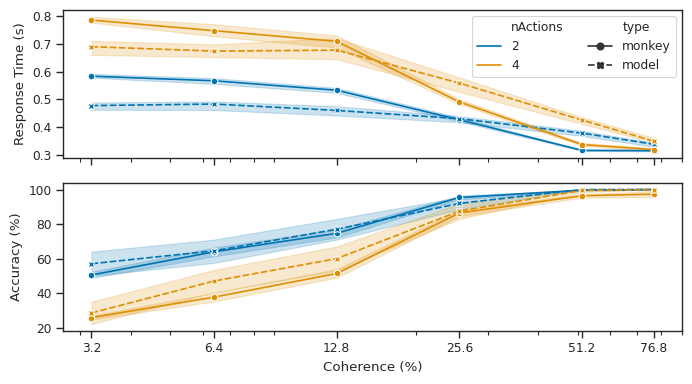

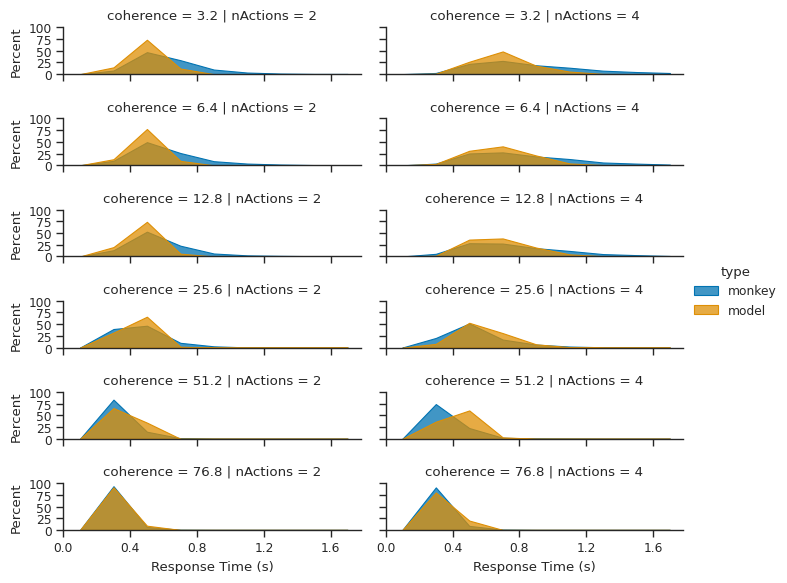

In [9]:
simulate(ramp=1.54, relative=0.0, threshold=0.32, trials=200, name="dec14abs", estimator=np.median,
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03, load=False)

nActions 2, coherence 0.032, trial 0, RT 0.523
nActions 2, coherence 0.032, trial 1, RT 0.486
nActions 2, coherence 0.032, trial 2, RT 1.0090000000000001
nActions 2, coherence 0.032, trial 3, RT 0.517
nActions 2, coherence 0.032, trial 4, RT 3.001
nActions 2, coherence 0.032, trial 5, RT 2.969
nActions 2, coherence 0.032, trial 6, RT 1.1320000000000001
nActions 2, coherence 0.032, trial 7, RT 0.91
nActions 2, coherence 0.032, trial 8, RT 0.855
nActions 2, coherence 0.032, trial 9, RT 1.0050000000000001
nActions 2, coherence 0.032, trial 10, RT 1.024
nActions 2, coherence 0.032, trial 11, RT 1.0230000000000001
nActions 2, coherence 0.032, trial 12, RT 1.802
nActions 2, coherence 0.032, trial 13, RT 0.784
nActions 2, coherence 0.032, trial 14, RT 0.464
nActions 2, coherence 0.032, trial 15, RT 0.741
nActions 2, coherence 0.032, trial 16, RT 1.962
nActions 2, coherence 0.032, trial 17, RT 2.241
nActions 2, coherence 0.032, trial 18, RT 0.64
nActions 2, coherence 0.032, trial 19, RT 1.131


nActions 2, coherence 0.032, trial 167, RT 0.552
nActions 2, coherence 0.032, trial 168, RT 0.562
nActions 2, coherence 0.032, trial 169, RT 0.86
nActions 2, coherence 0.032, trial 170, RT 0.599
nActions 2, coherence 0.032, trial 171, RT 1.165
nActions 2, coherence 0.032, trial 172, RT 2.1590000000000003
nActions 2, coherence 0.032, trial 173, RT 0.62
nActions 2, coherence 0.032, trial 174, RT 1.596
nActions 2, coherence 0.032, trial 175, RT 1.094
nActions 2, coherence 0.032, trial 176, RT 0.29
nActions 2, coherence 0.032, trial 177, RT 0.605
nActions 2, coherence 0.032, trial 178, RT 1.603
nActions 2, coherence 0.032, trial 179, RT 0.651
nActions 2, coherence 0.032, trial 180, RT 2.704
nActions 2, coherence 0.032, trial 181, RT 0.62
nActions 2, coherence 0.032, trial 182, RT 0.484
nActions 2, coherence 0.032, trial 183, RT 1.408
nActions 2, coherence 0.032, trial 184, RT 3.001
nActions 2, coherence 0.032, trial 185, RT 0.6920000000000001
nActions 2, coherence 0.032, trial 186, RT 1.85

nActions 2, coherence 0.064, trial 131, RT 0.836
nActions 2, coherence 0.064, trial 132, RT 0.445
nActions 2, coherence 0.064, trial 133, RT 0.5
nActions 2, coherence 0.064, trial 134, RT 0.8310000000000001
nActions 2, coherence 0.064, trial 135, RT 1.223
nActions 2, coherence 0.064, trial 136, RT 0.312
nActions 2, coherence 0.064, trial 137, RT 0.979
nActions 2, coherence 0.064, trial 138, RT 1.542
nActions 2, coherence 0.064, trial 139, RT 1.574
nActions 2, coherence 0.064, trial 140, RT 1.363
nActions 2, coherence 0.064, trial 141, RT 0.446
nActions 2, coherence 0.064, trial 142, RT 0.396
nActions 2, coherence 0.064, trial 143, RT 0.718
nActions 2, coherence 0.064, trial 144, RT 1.026
nActions 2, coherence 0.064, trial 145, RT 1.217
nActions 2, coherence 0.064, trial 146, RT 2.3040000000000003
nActions 2, coherence 0.064, trial 147, RT 0.763
nActions 2, coherence 0.064, trial 148, RT 0.247
nActions 2, coherence 0.064, trial 149, RT 0.537
nActions 2, coherence 0.064, trial 150, RT 1.

nActions 2, coherence 0.128, trial 97, RT 0.442
nActions 2, coherence 0.128, trial 98, RT 0.241
nActions 2, coherence 0.128, trial 99, RT 0.55
nActions 2, coherence 0.128, trial 100, RT 0.721
nActions 2, coherence 0.128, trial 101, RT 0.262
nActions 2, coherence 0.128, trial 102, RT 0.34400000000000003
nActions 2, coherence 0.128, trial 103, RT 1.497
nActions 2, coherence 0.128, trial 104, RT 1.0110000000000001
nActions 2, coherence 0.128, trial 105, RT 0.742
nActions 2, coherence 0.128, trial 106, RT 0.73
nActions 2, coherence 0.128, trial 107, RT 0.681
nActions 2, coherence 0.128, trial 108, RT 0.391
nActions 2, coherence 0.128, trial 109, RT 1.811
nActions 2, coherence 0.128, trial 110, RT 0.706
nActions 2, coherence 0.128, trial 111, RT 0.321
nActions 2, coherence 0.128, trial 112, RT 0.20400000000000001
nActions 2, coherence 0.128, trial 113, RT 0.323
nActions 2, coherence 0.128, trial 114, RT 0.852
nActions 2, coherence 0.128, trial 115, RT 0.865
nActions 2, coherence 0.128, tria

nActions 2, coherence 0.256, trial 60, RT 0.228
nActions 2, coherence 0.256, trial 61, RT 0.7000000000000001
nActions 2, coherence 0.256, trial 62, RT 0.28300000000000003
nActions 2, coherence 0.256, trial 63, RT 1.238
nActions 2, coherence 0.256, trial 64, RT 0.901
nActions 2, coherence 0.256, trial 65, RT 0.355
nActions 2, coherence 0.256, trial 66, RT 0.638
nActions 2, coherence 0.256, trial 67, RT 0.482
nActions 2, coherence 0.256, trial 68, RT 0.541
nActions 2, coherence 0.256, trial 69, RT 0.482
nActions 2, coherence 0.256, trial 70, RT 0.5650000000000001
nActions 2, coherence 0.256, trial 71, RT 0.274
nActions 2, coherence 0.256, trial 72, RT 0.382
nActions 2, coherence 0.256, trial 73, RT 0.28600000000000003
nActions 2, coherence 0.256, trial 74, RT 0.359
nActions 2, coherence 0.256, trial 75, RT 0.28300000000000003
nActions 2, coherence 0.256, trial 76, RT 0.47900000000000004
nActions 2, coherence 0.256, trial 77, RT 0.418
nActions 2, coherence 0.256, trial 78, RT 0.503
nActio

nActions 2, coherence 0.512, trial 21, RT 0.359
nActions 2, coherence 0.512, trial 22, RT 0.262
nActions 2, coherence 0.512, trial 23, RT 0.23
nActions 2, coherence 0.512, trial 24, RT 0.21
nActions 2, coherence 0.512, trial 25, RT 0.313
nActions 2, coherence 0.512, trial 26, RT 0.279
nActions 2, coherence 0.512, trial 27, RT 0.364
nActions 2, coherence 0.512, trial 28, RT 0.225
nActions 2, coherence 0.512, trial 29, RT 0.22
nActions 2, coherence 0.512, trial 30, RT 0.251
nActions 2, coherence 0.512, trial 31, RT 0.439
nActions 2, coherence 0.512, trial 32, RT 0.269
nActions 2, coherence 0.512, trial 33, RT 0.417
nActions 2, coherence 0.512, trial 34, RT 0.193
nActions 2, coherence 0.512, trial 35, RT 0.261
nActions 2, coherence 0.512, trial 36, RT 0.343
nActions 2, coherence 0.512, trial 37, RT 0.225
nActions 2, coherence 0.512, trial 38, RT 0.26
nActions 2, coherence 0.512, trial 39, RT 0.488
nActions 2, coherence 0.512, trial 40, RT 0.216
nActions 2, coherence 0.512, trial 41, RT 0.

nActions 2, coherence 0.512, trial 184, RT 0.314
nActions 2, coherence 0.512, trial 185, RT 0.352
nActions 2, coherence 0.512, trial 186, RT 0.445
nActions 2, coherence 0.512, trial 187, RT 0.179
nActions 2, coherence 0.512, trial 188, RT 0.5680000000000001
nActions 2, coherence 0.512, trial 189, RT 0.42
nActions 2, coherence 0.512, trial 190, RT 0.312
nActions 2, coherence 0.512, trial 191, RT 0.251
nActions 2, coherence 0.512, trial 192, RT 0.20800000000000002
nActions 2, coherence 0.512, trial 193, RT 0.457
nActions 2, coherence 0.512, trial 194, RT 0.40800000000000003
nActions 2, coherence 0.512, trial 195, RT 0.23800000000000002
nActions 2, coherence 0.512, trial 196, RT 0.28
nActions 2, coherence 0.512, trial 197, RT 0.456
nActions 2, coherence 0.512, trial 198, RT 0.224
nActions 2, coherence 0.512, trial 199, RT 0.495
nActions 2, coherence 0.768, trial 0, RT 0.184
nActions 2, coherence 0.768, trial 1, RT 0.20600000000000002
nActions 2, coherence 0.768, trial 2, RT 0.225
nActions

nActions 2, coherence 0.768, trial 147, RT 0.219
nActions 2, coherence 0.768, trial 148, RT 0.203
nActions 2, coherence 0.768, trial 149, RT 0.233
nActions 2, coherence 0.768, trial 150, RT 0.193
nActions 2, coherence 0.768, trial 151, RT 0.305
nActions 2, coherence 0.768, trial 152, RT 0.447
nActions 2, coherence 0.768, trial 153, RT 0.276
nActions 2, coherence 0.768, trial 154, RT 0.225
nActions 2, coherence 0.768, trial 155, RT 0.23600000000000002
nActions 2, coherence 0.768, trial 156, RT 0.319
nActions 2, coherence 0.768, trial 157, RT 0.162
nActions 2, coherence 0.768, trial 158, RT 0.171
nActions 2, coherence 0.768, trial 159, RT 0.25
nActions 2, coherence 0.768, trial 160, RT 0.234
nActions 2, coherence 0.768, trial 161, RT 0.259
nActions 2, coherence 0.768, trial 162, RT 0.318
nActions 2, coherence 0.768, trial 163, RT 0.196
nActions 2, coherence 0.768, trial 164, RT 0.268
nActions 2, coherence 0.768, trial 165, RT 0.179
nActions 2, coherence 0.768, trial 166, RT 0.268
nAction

nActions 4, coherence 0.032, trial 113, RT 0.886
nActions 4, coherence 0.032, trial 114, RT 0.501
nActions 4, coherence 0.032, trial 115, RT 0.972
nActions 4, coherence 0.032, trial 116, RT 1.228
nActions 4, coherence 0.032, trial 117, RT 0.79
nActions 4, coherence 0.032, trial 118, RT 0.6
nActions 4, coherence 0.032, trial 119, RT 0.851
nActions 4, coherence 0.032, trial 120, RT 0.64
nActions 4, coherence 0.032, trial 121, RT 0.512
nActions 4, coherence 0.032, trial 122, RT 1.01
nActions 4, coherence 0.032, trial 123, RT 0.518
nActions 4, coherence 0.032, trial 124, RT 0.9550000000000001
nActions 4, coherence 0.032, trial 125, RT 0.327
nActions 4, coherence 0.032, trial 126, RT 0.524
nActions 4, coherence 0.032, trial 127, RT 0.47600000000000003
nActions 4, coherence 0.032, trial 128, RT 1.544
nActions 4, coherence 0.032, trial 129, RT 1.823
nActions 4, coherence 0.032, trial 130, RT 1.161
nActions 4, coherence 0.032, trial 131, RT 0.723
nActions 4, coherence 0.032, trial 132, RT 0.87

nActions 4, coherence 0.064, trial 77, RT 0.578
nActions 4, coherence 0.064, trial 78, RT 1.073
nActions 4, coherence 0.064, trial 79, RT 0.41000000000000003
nActions 4, coherence 0.064, trial 80, RT 1.201
nActions 4, coherence 0.064, trial 81, RT 0.714
nActions 4, coherence 0.064, trial 82, RT 0.9430000000000001
nActions 4, coherence 0.064, trial 83, RT 0.91
nActions 4, coherence 0.064, trial 84, RT 0.326
nActions 4, coherence 0.064, trial 85, RT 0.625
nActions 4, coherence 0.064, trial 86, RT 0.46
nActions 4, coherence 0.064, trial 87, RT 0.75
nActions 4, coherence 0.064, trial 88, RT 0.44
nActions 4, coherence 0.064, trial 89, RT 0.8250000000000001
nActions 4, coherence 0.064, trial 90, RT 1.163
nActions 4, coherence 0.064, trial 91, RT 0.312
nActions 4, coherence 0.064, trial 92, RT 1.302
nActions 4, coherence 0.064, trial 93, RT 0.93
nActions 4, coherence 0.064, trial 94, RT 0.44
nActions 4, coherence 0.064, trial 95, RT 0.675
nActions 4, coherence 0.064, trial 96, RT 0.309
nActio

nActions 4, coherence 0.128, trial 42, RT 0.713
nActions 4, coherence 0.128, trial 43, RT 0.437
nActions 4, coherence 0.128, trial 44, RT 0.712
nActions 4, coherence 0.128, trial 45, RT 1.321
nActions 4, coherence 0.128, trial 46, RT 0.681
nActions 4, coherence 0.128, trial 47, RT 0.383
nActions 4, coherence 0.128, trial 48, RT 1.449
nActions 4, coherence 0.128, trial 49, RT 0.494
nActions 4, coherence 0.128, trial 50, RT 0.308
nActions 4, coherence 0.128, trial 51, RT 0.777
nActions 4, coherence 0.128, trial 52, RT 0.439
nActions 4, coherence 0.128, trial 53, RT 0.882
nActions 4, coherence 0.128, trial 54, RT 0.372
nActions 4, coherence 0.128, trial 55, RT 0.8200000000000001
nActions 4, coherence 0.128, trial 56, RT 0.537
nActions 4, coherence 0.128, trial 57, RT 0.905
nActions 4, coherence 0.128, trial 58, RT 0.20800000000000002
nActions 4, coherence 0.128, trial 59, RT 0.325
nActions 4, coherence 0.128, trial 60, RT 0.47300000000000003
nActions 4, coherence 0.128, trial 61, RT 0.403

nActions 4, coherence 0.256, trial 5, RT 0.336
nActions 4, coherence 0.256, trial 6, RT 0.773
nActions 4, coherence 0.256, trial 7, RT 0.355
nActions 4, coherence 0.256, trial 8, RT 0.391
nActions 4, coherence 0.256, trial 9, RT 0.798
nActions 4, coherence 0.256, trial 10, RT 0.808
nActions 4, coherence 0.256, trial 11, RT 0.17400000000000002
nActions 4, coherence 0.256, trial 12, RT 0.736
nActions 4, coherence 0.256, trial 13, RT 0.548
nActions 4, coherence 0.256, trial 14, RT 0.442
nActions 4, coherence 0.256, trial 15, RT 0.292
nActions 4, coherence 0.256, trial 16, RT 0.364
nActions 4, coherence 0.256, trial 17, RT 0.373
nActions 4, coherence 0.256, trial 18, RT 1.311
nActions 4, coherence 0.256, trial 19, RT 0.435
nActions 4, coherence 0.256, trial 20, RT 0.502
nActions 4, coherence 0.256, trial 21, RT 0.258
nActions 4, coherence 0.256, trial 22, RT 0.326
nActions 4, coherence 0.256, trial 23, RT 0.396
nActions 4, coherence 0.256, trial 24, RT 0.788
nActions 4, coherence 0.256, tr

nActions 4, coherence 0.256, trial 171, RT 0.388
nActions 4, coherence 0.256, trial 172, RT 0.87
nActions 4, coherence 0.256, trial 173, RT 0.97
nActions 4, coherence 0.256, trial 174, RT 1.094
nActions 4, coherence 0.256, trial 175, RT 0.618
nActions 4, coherence 0.256, trial 176, RT 0.341
nActions 4, coherence 0.256, trial 177, RT 0.34800000000000003
nActions 4, coherence 0.256, trial 178, RT 0.28200000000000003
nActions 4, coherence 0.256, trial 179, RT 0.561
nActions 4, coherence 0.256, trial 180, RT 0.651
nActions 4, coherence 0.256, trial 181, RT 0.392
nActions 4, coherence 0.256, trial 182, RT 0.516
nActions 4, coherence 0.256, trial 183, RT 0.639
nActions 4, coherence 0.256, trial 184, RT 0.8170000000000001
nActions 4, coherence 0.256, trial 185, RT 0.377
nActions 4, coherence 0.256, trial 186, RT 0.584
nActions 4, coherence 0.256, trial 187, RT 0.5710000000000001
nActions 4, coherence 0.256, trial 188, RT 0.356
nActions 4, coherence 0.256, trial 189, RT 0.56
nActions 4, cohere

nActions 4, coherence 0.512, trial 137, RT 0.321
nActions 4, coherence 0.512, trial 138, RT 0.216
nActions 4, coherence 0.512, trial 139, RT 0.29
nActions 4, coherence 0.512, trial 140, RT 0.338
nActions 4, coherence 0.512, trial 141, RT 0.215
nActions 4, coherence 0.512, trial 142, RT 0.306
nActions 4, coherence 0.512, trial 143, RT 0.372
nActions 4, coherence 0.512, trial 144, RT 0.447
nActions 4, coherence 0.512, trial 145, RT 0.448
nActions 4, coherence 0.512, trial 146, RT 0.301
nActions 4, coherence 0.512, trial 147, RT 0.266
nActions 4, coherence 0.512, trial 148, RT 0.378
nActions 4, coherence 0.512, trial 149, RT 0.314
nActions 4, coherence 0.512, trial 150, RT 0.322
nActions 4, coherence 0.512, trial 151, RT 0.28600000000000003
nActions 4, coherence 0.512, trial 152, RT 0.352
nActions 4, coherence 0.512, trial 153, RT 0.221
nActions 4, coherence 0.512, trial 154, RT 0.211
nActions 4, coherence 0.512, trial 155, RT 0.262
nActions 4, coherence 0.512, trial 156, RT 0.315
nAction

nActions 4, coherence 0.768, trial 102, RT 0.186
nActions 4, coherence 0.768, trial 103, RT 0.23
nActions 4, coherence 0.768, trial 104, RT 0.324
nActions 4, coherence 0.768, trial 105, RT 0.259
nActions 4, coherence 0.768, trial 106, RT 0.23700000000000002
nActions 4, coherence 0.768, trial 107, RT 0.227
nActions 4, coherence 0.768, trial 108, RT 0.249
nActions 4, coherence 0.768, trial 109, RT 0.162
nActions 4, coherence 0.768, trial 110, RT 0.25
nActions 4, coherence 0.768, trial 111, RT 0.19
nActions 4, coherence 0.768, trial 112, RT 0.311
nActions 4, coherence 0.768, trial 113, RT 0.203
nActions 4, coherence 0.768, trial 114, RT 0.18
nActions 4, coherence 0.768, trial 115, RT 0.262
nActions 4, coherence 0.768, trial 116, RT 0.194
nActions 4, coherence 0.768, trial 117, RT 0.28500000000000003
nActions 4, coherence 0.768, trial 118, RT 0.222
nActions 4, coherence 0.768, trial 119, RT 0.20800000000000002
nActions 4, coherence 0.768, trial 120, RT 0.245
nActions 4, coherence 0.768, tr

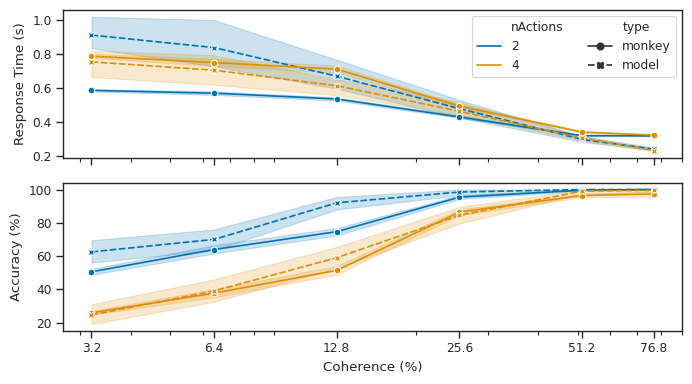

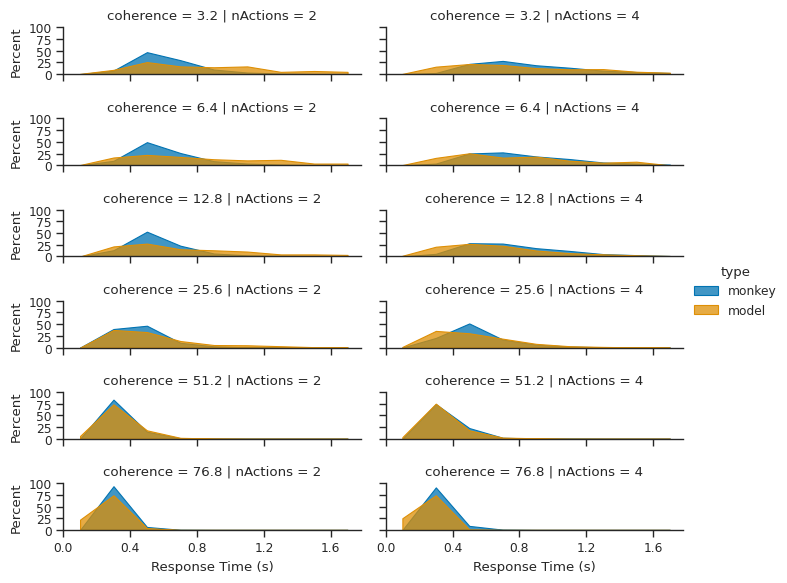

In [10]:
simulate(ramp=1.73, relative=1.0, threshold=0.16, trials=200, name="dec14rel", estimator=np.median,
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03, load=False)

# Firing Rate Experiments

In [13]:
def rate_experiment(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512, 0.768],
        nAs=[2,4],
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        nNeurons=1000,
        max_rates=nengo.dists.Uniform(100, 200),
        rA=4.0,
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        tmax=3,
        t0=0.15,
        t1=0.3,
        t2=-0.3,
        name="default"):
    
    if not load:
        dfs = []
        for nActions in nAs:
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                inputs.create(coherence=coherence)
                for trial in range(trials):
                    net = build_network(inputs, nActions=nActions, seed=trial,
                                        ramp=ramp, threshold=threshold, relative=relative,
                                        nNeurons=nNeurons, rA=rA, max_rates=max_rates, probe_spikes=True)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = 1 if choice==net.inputs.correct else 0
                    print(f"trial {trial}, coherence {coherence}, nActions {nActions}, correct {correct}, RT {RT}")
                    aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,net.inputs.correct] > 0.9)
                    for neuron in aligned_neuron_idx:
                        df = pd.DataFrame()
                        df['time'] = sim.trange()
                        df['time2'] = -1*sim.trange()[::-1]
                        df['nActions'] =  nActions*np.ones_like(sim.trange())
                        df['coherence'] =  100*coherence*np.ones_like(sim.trange())
                        df['trial'] =  trial*np.ones_like(sim.trange())
                        df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                        df['RT'] = RT*np.ones_like(sim.trange())
                        df['neuron'] = neuron*np.ones_like(sim.trange())
                        df['firing rate'] = sim.data[net.pSpikes][:,neuron].ravel()
                        df['evidence'] = sim.data[net.pAccumulator][:,net.inputs.correct].ravel()
                        df['value'] = sim.data[net.pValue][:,net.inputs.correct].ravel()
                        dfs.append(df)
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}_firing_rates.pkl")
    else:
        data = pd.read_pickle(f"data/{name}_firing_rates.pkl")

    data_start = data.query("time>@t0 & time<@t1")
    data_end = data.query("time2>@t2")
    # palette2 = sns.color_palette("viridis", len(data['coherence'].unique()))
    palette2 = palette[:len(coherences)]

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    sns.lineplot(data=data_start, x='time', y='firing rate', hue="coherence", style='nActions', palette=palette2, ax=axes[0])
    sns.lineplot(data=data_end, x='time2', y='firing rate', hue="coherence", style='nActions', palette=palette2, ax=axes[1])
    axes[0].set(xlabel="Time After Stimulus (s)", ylabel="Firing Rate (Hz)", title=f"Ramping Activities")
    axes[1].set(xlabel="Time Before Response (s)", ylabel=None, title=f"Converging Activities")
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/{name}_firing_rates.svg")
    fig.savefig(f"plots/{name}_firing_rates.png", dpi=600)

## Simulate (rates)

trial 0, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 20, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 21, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 22, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 23, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 24, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 25, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 26, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 27, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 28, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 29, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 30, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 31, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 32, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 33, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 34, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 35, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 36, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 37, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 38, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 39, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 40, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 41, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 42, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 43, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 44, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 45, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 46, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 47, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 48, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 49, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 20, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 21, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 22, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 23, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 24, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 25, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 26, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 27, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 28, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 29, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 30, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 31, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 32, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 33, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 34, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 35, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 36, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 37, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 38, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 39, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 40, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 41, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 42, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 43, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 44, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 45, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 46, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 47, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 48, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 49, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 20, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 21, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 22, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 23, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 24, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 25, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 26, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 27, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 28, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 29, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 30, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 31, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 32, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 33, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 34, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 35, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 36, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 37, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 38, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 39, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 40, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 41, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 42, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 43, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 44, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 45, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 46, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 47, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 48, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 49, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 20, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 21, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 22, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 23, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 24, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 25, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 26, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 27, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 28, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 29, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 30, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 31, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 32, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 33, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 34, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 35, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 36, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 37, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 38, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 39, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 40, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 41, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 42, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 43, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 44, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 45, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 46, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 47, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 48, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 49, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


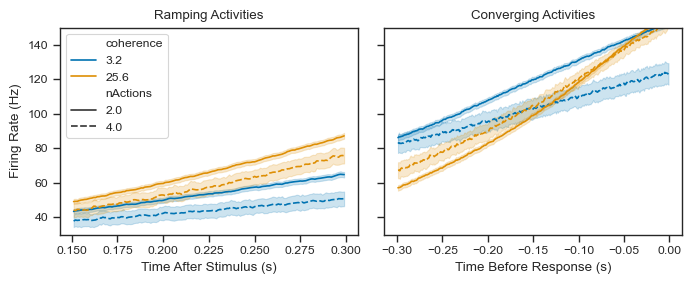

In [24]:
rate_experiment(coherences=[0.032, 0.256], ramp=1.3, relative=0.48, threshold=0.21,
                nNeurons=500, rA=2.0, max_rates=nengo.dists.Uniform(50, 100), name='nov24a2', trials=50, load=False)

trial 0, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


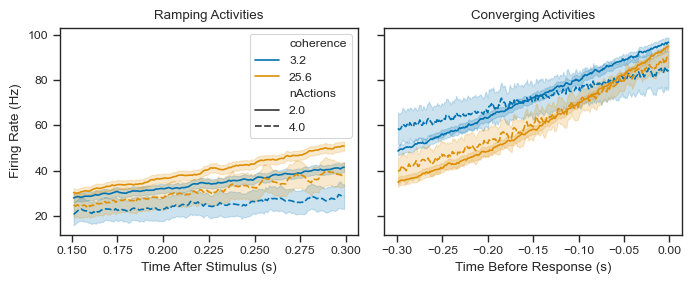

In [41]:
rate_experiment(coherences=[0.032, 0.256], ramp=2.0, relative=0.3, threshold=0.4, name="dec11b2",
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100),
         rA=1.5, sigma=0.5, dt_sample=0.03, trials=10, load=False)

trial 0, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.032, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.256, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.032, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


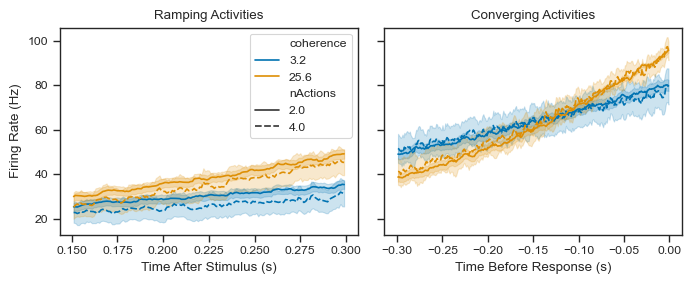

In [62]:
rate_experiment(coherences=[0.032, 0.256], ramp=1.07, relative=0.61, threshold=0.17, name="dec13a",
         nNeurons=500, max_rates=nengo.dists.Uniform(80, 100), rA=1.5, sigma=0.5, dt_sample=0.03, trials=10, load=False)

### hanks

/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 0, coherence 0.032, nActions 2, correct 1, RT 0.393
trial 1, coherence 0.032, nActions 2, correct 1, RT 0.529
trial 2, coherence 0.032, nActions 2, correct 1, RT 0.433
trial 3, coherence 0.032, nActions 2, correct 1, RT 0.387
trial 4, coherence 0.032, nActions 2, correct 0, RT 0.54
trial 5, coherence 0.032, nActions 2, correct 1, RT 0.385
trial 6, coherence 0.032, nActions 2, correct 1, RT 0.456


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 7, coherence 0.032, nActions 2, correct 0, RT 0.335
trial 8, coherence 0.032, nActions 2, correct 1, RT 0.375


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 9, coherence 0.032, nActions 2, correct 1, RT 0.617
trial 10, coherence 0.032, nActions 2, correct 1, RT 0.47100000000000003


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 11, coherence 0.032, nActions 2, correct 1, RT 0.497


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 12, coherence 0.032, nActions 2, correct 1, RT 0.34600000000000003


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 13, coherence 0.032, nActions 2, correct 1, RT 0.354
trial 14, coherence 0.032, nActions 2, correct 0, RT 0.458
trial 15, coherence 0.032, nActions 2, correct 1, RT 0.335
trial 16, coherence 0.032, nActions 2, correct 0, RT 0.337
trial 17, coherence 0.032, nActions 2, correct 1, RT 0.422


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 18, coherence 0.032, nActions 2, correct 0, RT 0.445
trial 19, coherence 0.032, nActions 2, correct 1, RT 0.609
trial 20, coherence 0.032, nActions 2, correct 0, RT 0.384
trial 21, coherence 0.032, nActions 2, correct 0, RT 0.334


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 22, coherence 0.032, nActions 2, correct 0, RT 0.41200000000000003


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 23, coherence 0.032, nActions 2, correct 1, RT 0.307
trial 24, coherence 0.032, nActions 2, correct 0, RT 0.488
trial 25, coherence 0.032, nActions 2, correct 0, RT 0.396
trial 26, coherence 0.032, nActions 2, correct 0, RT 0.397
trial 27, coherence 0.032, nActions 2, correct 0, RT 0.532
trial 28, coherence 0.032, nActions 2, correct 0, RT 0.455
trial 29, coherence 0.032, nActions 2, correct 1, RT 0.391
trial 0, coherence 0.512, nActions 2, correct 1, RT 0.306
trial 1, coherence 0.512, nActions 2, correct 1, RT 0.359
trial 2, coherence 0.512, nActions 2, correct 1, RT 0.316
trial 3, coherence 0.512, nActions 2, correct 1, RT 0.331
trial 4, coherence 0.512, nActions 2, correct 1, RT 0.281


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 5, coherence 0.512, nActions 2, correct 1, RT 0.272


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 6, coherence 0.512, nActions 2, correct 1, RT 0.32


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 7, coherence 0.512, nActions 2, correct 1, RT 0.353


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 8, coherence 0.512, nActions 2, correct 1, RT 0.251
trial 9, coherence 0.512, nActions 2, correct 1, RT 0.264


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 10, coherence 0.512, nActions 2, correct 1, RT 0.355
trial 11, coherence 0.512, nActions 2, correct 1, RT 0.275
trial 12, coherence 0.512, nActions 2, correct 1, RT 0.316
trial 13, coherence 0.512, nActions 2, correct 1, RT 0.34800000000000003
trial 14, coherence 0.512, nActions 2, correct 1, RT 0.332
trial 15, coherence 0.512, nActions 2, correct 1, RT 0.324
trial 16, coherence 0.512, nActions 2, correct 1, RT 0.305
trial 17, coherence 0.512, nActions 2, correct 1, RT 0.417
trial 18, coherence 0.512, nActions 2, correct 1, RT 0.359


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 19, coherence 0.512, nActions 2, correct 1, RT 0.253
trial 20, coherence 0.512, nActions 2, correct 1, RT 0.381
trial 21, coherence 0.512, nActions 2, correct 1, RT 0.34700000000000003


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 22, coherence 0.512, nActions 2, correct 1, RT 0.34500000000000003
trial 23, coherence 0.512, nActions 2, correct 1, RT 0.267
trial 24, coherence 0.512, nActions 2, correct 1, RT 0.34800000000000003


/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 25, coherence 0.512, nActions 2, correct 1, RT 0.406
trial 26, coherence 0.512, nActions 2, correct 1, RT 0.342
trial 27, coherence 0.512, nActions 2, correct 1, RT 0.335
trial 28, coherence 0.512, nActions 2, correct 1, RT 0.323
trial 29, coherence 0.512, nActions 2, correct 1, RT 0.49


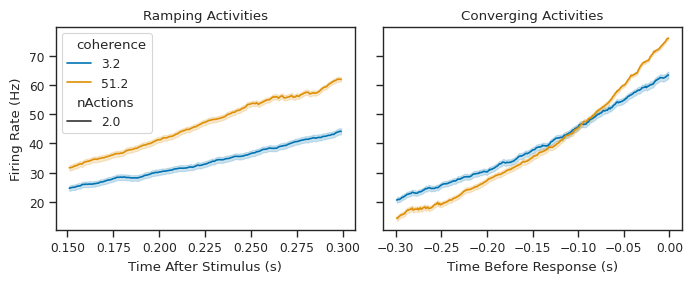

In [14]:
rate_experiment(coherences=[0.032, 0.512], nAs=[2],
                max_rates=nengo.dists.Uniform(60, 80),
                ramp=1.82, relative=0.28, threshold=0.28,
                name="dec29shareTL",
                nNeurons=500, 
                rA=1.5, sigma=0.5, dt_sample=0.03, trials=30, load=False)

## Churchland dataframe

### Warning: makes a 2GB pickle file

In [29]:
def make_churchland_firing_dataframe():
    # convert original matlab files into a single pandas dataframe
    # coherences = [0.0, 0.032, 0.064, 0.128, 0.256, 0.514, 0.768]
    dfs = []
    columns = ('nActions', 'coherence', 'trial', 'neuron', 'accuracy', 'time', 'time2', 'firing rate')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times
    pref = 1  # preferred direction 

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            nCoherences = len(emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'])
            for c in range(nCoherences):
                # select preferred direction (pref) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                dat = emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    if type(dat[trial]['rt'])!=float: continue
                    RT = int(dat[trial]['rt'])
                    coherence = float(dat[trial]['coh']) / 10
                    spike_times = dat[trial]['dots']
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(spike_times)!=np.ndarray or len(spike_times)==0:  continue  # skip empty data
                    spike_times = np.array(dat[trial]['dots']).astype(int)  # remove sub-ms precision in spike times
                    tstart = spike_times[0]
                    tend = spike_times[-1]+1
                    times = np.arange(tstart, tend)/1000  # time relative to stimulus onset, in seconds
                    times2 = np.arange(tstart-tend, 0)/1000  # time relative to response, in seconds
                    spike_array = np.zeros_like(times)
                    spike_array[spike_times-tstart] = 1  # put a value of 1 at the index of every spike time
                    firing_rates = filter.filt(1000*spike_array)  # compute firing rate in spikes/second (Hz) by filtering with lowpass filter
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=100/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    df = pd.DataFrame()
                    df['nActions'] = nActions*np.ones_like(times)
                    df['coherence'] = coherence*np.ones_like(times)
                    df['trial'] = trial*np.ones_like(times)
                    df['neuron'] = neuron*np.ones_like(times)
                    df['RT'] = RT*np.ones_like(times)
                    df['accuracy'] = accuracy*np.ones_like(times)
                    df['nActions'] = nActions*np.ones_like(times)
                    df['time'] = times
                    df['time2'] = times2
                    df['firing rate'] = firing_rates
                    dfs.append(df)

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_firing.pkl")

In [ ]:
churchland_firing = make_churchland_firing_dataframe()

In [18]:
def plot_churchland_firing(coherences=[0.032, 0.256], t0=0.15, t1=0.4, t2=-0.4, t3=-0.05):
    churchland = pd.read_pickle("data/churchland2008_firing.pkl")
    coh = 100*np.array(coherences)
    subdata2_start = churchland.query("nActions==2 & time>@t0 & time<@t1 & coherence in @coh & accuracy==100")
    subdata2_end = churchland.query("nActions==2 & time2>@t2 & time2<@t3 & coherence in @coh & accuracy==100")
    subdata4_start = churchland.query("nActions==4 & time>@t0 & time<@t1 & coherence in @coh & accuracy==100")
    subdata4_end = churchland.query("nActions==4 & time2>@t2 & time2<@t3 & coherence in @coh & accuracy==100")
    del(churchland)

    palette2 = palette[:len(coherences)]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((7.08, 4)), sharey=True, sharex='col')
    sns.lineplot(data=subdata2_start, x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][0])
    sns.lineplot(data=subdata2_end, x='time2', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][1])
    sns.lineplot(data=subdata4_start, x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[1][0])
    sns.lineplot(data=subdata4_end, x='time2', y='firing rate', hue="coherence", palette=palette2, ax=axes[1][1])
    axes[0][0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities (2 actions)')
    axes[0][1].set(xlabel='Time Before Response (s)', ylabel="Firing Rate (Hz)", title=f'Converging Activities (2 actions)')
    axes[1][0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities (4 actions)')
    axes[1][1].set(xlabel='Time Before Response (s)', ylabel="Firing Rate (Hz)", title=f'Converging Activities (4 actions)')
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_firing.svg")
    fig.savefig(f"plots/churchland_firing.png", dpi=600)

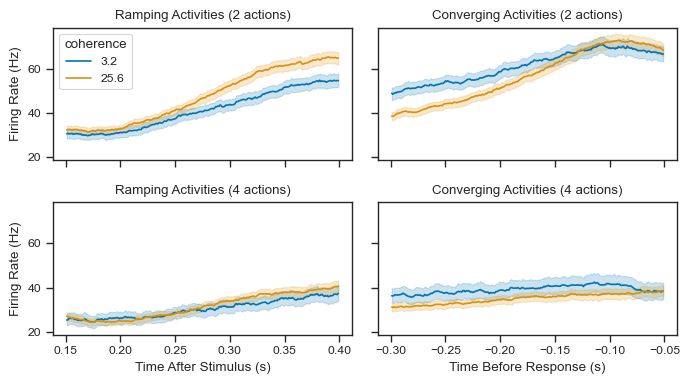

In [39]:
plot_churchland_firing()

## Compare

In [58]:
def compare_firing(sim, coherences=[0.032, 0.256], t0=0.1, t1=0.4, t2=-0.3, t3=-0.01):
    churchland = pd.read_pickle("data/churchland2008_firing.pkl")
    coh = 100*np.array(coherences)
    emp_start = churchland.query("time>@t0 & time<@t1 & coherence in @coh & accuracy==100 & nActions==2")
    emp_end = churchland.query("time2>@t2 & time2<@t3 & coherence in @coh & accuracy==100 & nActions==2")
    del(churchland)
    sim = pd.read_pickle(f"data/{sim}_firing_rates.pkl")
    sim_start = sim.query("time>@t0 & time<@t1")
    sim_end = sim.query("time2>@t2 & time2<@t3")

    a = ['monkey' for _ in range(emp_start.shape[0])]
    b = ['model' for _ in range(sim_start.shape[0])]
    c = ['monkey' for _ in range(emp_end.shape[0])]
    d = ['model' for _ in range(sim_end.shape[0])]
    emp_start.insert(0, 'type', a)
    sim_start.insert(0, 'type', b)
    emp_end.insert(0, 'type', c)
    sim_end.insert(0, 'type', d)
    combined_start = pd.concat([emp_start, sim_start], ignore_index=True)
    combined_end = pd.concat([emp_end, sim_end], ignore_index=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=True, sharex=False)
    sns.lineplot(data=combined_start, x='time', y='firing rate', hue="coherence", style='type', palette=palette[:2], ax=axes[0])
    sns.lineplot(data=combined_end, x='time2', y='firing rate', hue="coherence", style='type', palette=palette[:2], ax=axes[1])
    axes[0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title=f'Ramping Activities')  # , xlim=[0.15, 0.35])
    axes[1].set(xlabel='Time Before Response (s)', title=f'Converging Activities')  # , xlim=[-0.35, -0.05])
    axes[0].legend(loc="upper left", ncols=2)
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_churchland_firing2.svg")
    fig.savefig(f"plots/compare_churchland_firing2.png", dpi=600)

In [ ]:
compare_firing("nov24a2")

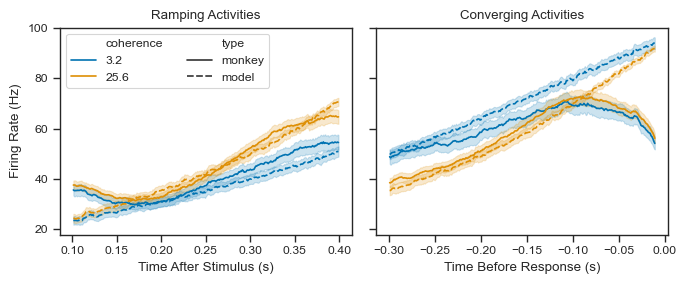

In [45]:
compare_firing("dec11b2")

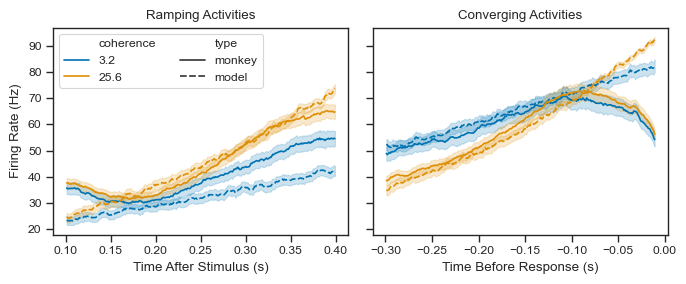

In [69]:
compare_firing("dec12b")

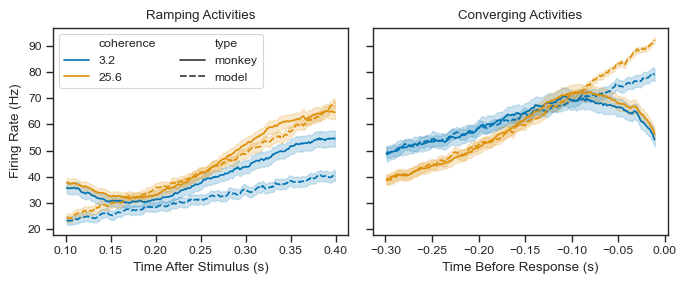

In [63]:
compare_firing("dec13a")